In [5]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch: 2.5.1
CUDA available: True


In [10]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch: 2.5.1
CUDA available: True


  Using cached xgboost-3.2.0-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.3 MB 5.6 MB/s eta 0:00:02
   ---- ----------------------------------- 1.3/11.3 MB 3.4 MB/s eta 0:00:03
   ------- -------------------------------- 2.1/11.3 MB 3.4 MB/s eta 0:00:03
   ---------- ----------------------------- 2.9/11.3 MB 3.5 MB/s eta 0:00:03
   ------------ --------------------------- 3.7/11.3 MB 3.5 MB/s eta 0:00:03
   --------------- ------------------------ 4.5/11.3 MB 3.6 MB/s eta 0:00:02
   ------------------ --------------------- 5.2/11.3 MB 3.7 MB/s eta

In [11]:
import xgboost as xgb
print(xgb.__version__)

3.2.0


In [9]:
# ============================================================
# CELL 1 (Plan B - Thesis Version)
# Slice-based splitting:
#   Each unique value of the main variable (txgain / mcs / airtime)
#   is treated as ONE independent slice.
#
# Important:
#   If you want to fully follow thesis logic,
#   your training loop (Cell2) must iterate over slices.
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------
# 1) Load dataset
# ------------------------------------------------------------
df = pd.read_csv("clean_ul_with_conditions2.csv")

# Target variable
target_col = "pm_power"

# ------------------------------------------------------------
# 2) Define slicing experiments
# ------------------------------------------------------------
EXPERIMENTS = {
    "gain": {
        "slice_col": "txgain",
        "feature_cols": ["selected_mcs", "airtime", "nRBs"]
    },
    "mcs": {
        "slice_col": "selected_mcs", 
        "feature_cols": ["txgain", "airtime", "nRBs"]
    },
    "airtime": {
        "slice_col": "airtime",
        "feature_cols": ["txgain", "selected_mcs", "nRBs"]
    },
}



# ------------------------------------------------------------
# 4) Data cleaning utility
# ------------------------------------------------------------
def clean_numeric_df(df, cols_needed, target_col):
    d = df.dropna(subset=cols_needed).copy()
    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=cols_needed).copy()
    d = d[d[target_col] > 0].copy()
    return d

# ------------------------------------------------------------
# 5) Slice-based split function
# ------------------------------------------------------------
def split_within_slice(
    d_slice,
    seed=42,
    train_ratio=0.8,
    val_ratio_within_train=0.1
):
    """
    Perform splitting INSIDE one slice.

    Step 1:
        Split into train and test
            train_ratio (default 80%)
            test_ratio  (default 20%)

    Step 2:
        From train part, split validation set
            val_ratio_within_train (default 10% of train)

    Final proportions (default):
        Train ≈ 72%
        Val   ≈ 8%
        Test  ≈ 20%
    """

    # First split: Train / Test
    train_df, test_df = train_test_split(
        d_slice,
        test_size=(1 - train_ratio),
        random_state=seed
    )

    # Second split: Train / Validation
    train_df, val_df = train_test_split(
        train_df,
        test_size=val_ratio_within_train,
        random_state=seed
    )

    return train_df, val_df, test_df



## Model 1 Config

-EPOCHS = 100
-BATCH_SIZE = 64
-LR = 1e-3
-SEED = 42

In [ ]:
# ============================================================
# CELL 2 (Plan B / Thesis slicing) — Model1 Baseline DNN
#
# Thesis slicing logic:
#   For each experiment (gain / mcs / airtime),
#   each unique value of the main variable is treated as ONE slice.
#   We train ONE model per slice.
#
# Inputs:
#   Use condition features only (COND_FEATURES),
#   because the main variable is fixed inside each slice.
# ============================================================

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


# ------------------------------------------------------------
# 1) Dataset wrapper for PyTorch
# ------------------------------------------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# ------------------------------------------------------------
# 2) Baseline DNN (Model 1)
# ------------------------------------------------------------
class BaselineDNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


# ------------------------------------------------------------
# 3) Mean Relative Error (percentage)
# ------------------------------------------------------------
def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100.0)


# ------------------------------------------------------------
# 4) Train & Eval one slice
# ------------------------------------------------------------
def train_eval_model1_slice(
    train_df,
    val_df,
    test_df,
    feature_cols,
    target_col,
    epochs=200,
    batch_size=64,
    lr=1e-3,
    seed=42,
    verbose_every=10
):
    # Reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Extract arrays
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values.astype(float)

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values.astype(float)

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values.astype(float)

    # Standardization (fit only on training)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    train_loader = DataLoader(TabularDataset(X_train_s, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TabularDataset(X_val_s,   y_val),   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(TabularDataset(X_test_s,  y_test),  batch_size=batch_size, shuffle=False)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = BaselineDNN(in_dim=len(feature_cols)).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val_loss = float("inf")
    best_state = None

    # Training loop
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(xb)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item() * len(xb)
        val_loss /= len(val_loader.dataset)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | Train MSE {train_loss:.6f} | Val MSE {val_loss:.6f}")

    model.load_state_dict(best_state)

    # Test eval
    model.eval()
    y_true_list, y_pred_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy().reshape(-1)
            y_pred_list.append(pred)
            y_true_list.append(yb.numpy().reshape(-1))

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mean_relative_error(y_true, y_pred)

    return {
        "mse": float(mse),
        "rmse": float(rmse),
        "mae": float(mae),
        "mre_pct": float(mre),
        "y_true": y_true,
        "y_pred": y_pred,
        "model": model,
        "scaler": scaler,
    }


# ------------------------------------------------------------
# 5) Thesis slicing experiment loop
# ------------------------------------------------------------
results = []
trained_models_m1_slices = {}     # trained_models_m1_slices[exp_name][slice_value] = {model, scaler}
test_outputs_m1_slices = {}       # optional: store predictions per slice

#MIN_SLICE_SIZE = 30  # 太小的 slice 就跳过（你可以调大/调小）

for exp_name, exp_cfg in EXPERIMENTS.items():
    slice_col    = exp_cfg["slice_col"]
    feature_cols = exp_cfg["feature_cols"]

    print("\n" + "="*70)
    print(f"Experiment: {exp_name} | slice_col = {slice_col}")
    print("="*70)

    #  # Required columns for this experiment ：slice_col + cond features + target
    cols_needed = [slice_col] + feature_cols + [target_col]

     # Clean dataframe (function defined in Cell 1)
    d = clean_numeric_df(df, cols_needed, target_col)

    # Ensure slice_col is numeric (avoid string grouping bugs)
    d[slice_col] = pd.to_numeric(d[slice_col], errors="coerce")
    d = d.dropna(subset=[slice_col]).copy()

    trained_models_m1_slices.setdefault(exp_name, {})
    test_outputs_m1_slices.setdefault(exp_name, {})

    # Train per slice
    for sval, d_slice in d.groupby(slice_col):
        d_slice = d_slice.copy()

        #if len(d_slice) < MIN_SLICE_SIZE:
            # 样本太少，不适合拆 train/val/test
            #continue

        # Split inside slice (function defined in Cell 1)
        train_df, val_df, test_df = split_within_slice(
            d_slice, seed=42, train_ratio=0.8, val_ratio_within_train=0.1
        )

        # 再做一个安全检查：避免 val/test 太小
        #if len(train_df) < 10 or len(val_df) < 5 or len(test_df) < 5:
            #continue

        print(f"\n--- slice {slice_col} = {sval} | sizes: "
              f"train={len(train_df)}, val={len(val_df)}, test={len(test_df)} ---")

        out = train_eval_model1_slice(
            train_df, val_df, test_df,
            feature_cols=exp_cfg["feature_cols"],   
            target_col=target_col,
            epochs=100,
            batch_size=64,
            lr=1e-3,
            seed=42,
            verbose_every=20
        )

        # Save summary metrics
        results.append({
            "experiment": exp_name,
            "slice_col": slice_col,
            "slice_value": float(sval),
            "model": "Model1 (BaselineDNN, slice-wise)",
            "features": ",".join(feature_cols),
            "MSE": out["mse"],
            "RMSE": out["rmse"],
            "MAE": out["mae"],
            "MRE(%)": out["mre_pct"],
            "n_train": len(train_df),
            "n_val": len(val_df),
            "n_test": len(test_df),
        })

        # Save trained objects
        trained_models_m1_slices[exp_name][float(sval)] = {
            "model": out["model"],
            "scaler": out["scaler"]
        }

        # Save test predictions
        test_outputs_m1_slices[exp_name][float(sval)] = {
            "test_df": test_df.copy(),
            "y_true": out["y_true"],
            "y_pred_m1": out["y_pred"],
        }


# Build final results table
results_df = pd.DataFrame(results)

print("\n=== Results (Model1) ===")
display(results_df)

print("\n=== Sorted by MRE(%) ===")
print(results_df.sort_values(["experiment", "MRE(%)"]))



Experiment: gain | slice_col = txgain

--- slice txgain = 20 | sizes: train=36, val=5, test=11 ---
Epoch 001 | Train MSE 119.573326 | Val MSE 120.809792
Epoch 020 | Train MSE 106.671303 | Val MSE 107.604080
Epoch 040 | Train MSE 63.631477 | Val MSE 62.909271
Epoch 060 | Train MSE 13.093489 | Val MSE 11.803134
Epoch 080 | Train MSE 5.964615 | Val MSE 5.729862
Epoch 100 | Train MSE 2.545863 | Val MSE 2.719381

--- slice txgain = 21 | sizes: train=43, val=5, test=12 ---
Epoch 001 | Train MSE 120.115067 | Val MSE 117.659111
Epoch 020 | Train MSE 107.281113 | Val MSE 104.489128
Epoch 040 | Train MSE 63.761345 | Val MSE 59.419628
Epoch 060 | Train MSE 14.067633 | Val MSE 4.551633
Epoch 080 | Train MSE 5.841825 | Val MSE 0.611083
Epoch 100 | Train MSE 2.205943 | Val MSE 0.372509

--- slice txgain = 22 | sizes: train=50, val=6, test=14 ---
Epoch 001 | Train MSE 121.568474 | Val MSE 125.180962
Epoch 020 | Train MSE 108.591713 | Val MSE 112.975548
Epoch 040 | Train MSE 65.304306 | Val MSE 70.78

,experiment,slice_col,slice_value,model,features,MSE,RMSE,MAE,MRE(%),n_train,n_val,n_test
0,gain,txgain,20.0,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",2.743154,1.656247,1.408199,12.744636,36,5,11
1,gain,txgain,21.0,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",2.190541,1.480048,1.388691,11.987913,43,5,12
2,gain,txgain,22.0,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",3.028780,1.740339,1.521969,13.680026,50,6,14
3,gain,txgain,23.0,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",8.498503,2.915219,2.240810,19.636181,57,7,16
4,gain,txgain,24.0,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",4.275484,2.067724,1.540355,13.866584,58,7,17
...,...,...,...,...,...,...,...,...,...,...,...,...
70,airtime,airtime,0.6,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",0.246497,0.496485,0.405982,3.489119,367,41,103
71,airtime,airtime,0.7,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",0.257739,0.507680,0.418153,3.574178,367,41,103
72,airtime,airtime,0.8,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",0.281604,0.530664,0.447496,3.709767,367,41,103
73,airtime,airtime,0.9,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",0.313237,0.559676,0.471684,3.859817,367,41,103



=== Sorted by MRE(%) ===
   experiment     slice_col  slice_value                             model  \
64    airtime       airtime          0.0  Model1 (BaselineDNN, slice-wise)   
67    airtime       airtime          0.3  Model1 (BaselineDNN, slice-wise)   
65    airtime       airtime          0.1  Model1 (BaselineDNN, slice-wise)   
66    airtime       airtime          0.2  Model1 (BaselineDNN, slice-wise)   
68    airtime       airtime          0.4  Model1 (BaselineDNN, slice-wise)   
..        ...           ...          ...                               ...   
58        mcs  selected_mcs          9.0  Model1 (BaselineDNN, slice-wise)   
60        mcs  selected_mcs         15.0  Model1 (BaselineDNN, slice-wise)   
61        mcs  selected_mcs         18.0  Model1 (BaselineDNN, slice-wise)   
63        mcs  selected_mcs         23.0  Model1 (BaselineDNN, slice-wise)   
62        mcs  selected_mcs         21.0  Model1 (BaselineDNN, slice-wise)   

                           features  



## Model 2 Config

EPOCHS = 100
BATCH_SIZE = 64
LR = 1e-3
WEIGHT_DECAY = 1e-2
DROPOUT = 0.3
SEED = 42
VERBOSE_EVERY = 20

In [11]:
# ============================================================
# CELL (Plan B / Thesis slicing) — Model2 RegularizedDNN
#
# Thesis slicing logic:
#   For each experiment (gain / mcs / airtime),
#   each unique value of the main variable is ONE slice.
#   Train ONE Model2 per slice.
#
# Inputs:
#   Use condition features only (COND_FEATURES),
#   since the main variable is fixed inside each slice.
# ============================================================

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


# ---------------------------
# Metric: MRE(%)
# ---------------------------
def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100.0)


# ---------------------------
# Model2: RegularizedDNN
# ---------------------------
class RegularizedDNN(nn.Module):
    def __init__(self, input_dim, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


# ---------------------------
# Train + Eval one slice
# ---------------------------
def train_eval_model2_slice(
    train_df, val_df, test_df,
    feature_cols, target_col,
    epochs=500, batch_size=16, lr=1e-3, weight_decay=1e-2,
    seed=42, verbose_every=20
):
    
     # -------------------------
    # Reproducibility
    # -------------------------
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # -------------------------
    # Extract arrays
    # -------------------------
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values.astype(float)

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values.astype(float)

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values.astype(float)

    print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)

    # -------------------------
    # Standardization (fit on train only)
    # -------------------------
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

     # Convert to tensors
    X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
    y_train_t = torch.tensor(y_train,   dtype=torch.float32).view(-1, 1)
    X_val_t   = torch.tensor(X_val_s,   dtype=torch.float32)
    y_val_t   = torch.tensor(y_val,     dtype=torch.float32).view(-1, 1)
    X_test_t  = torch.tensor(X_test_s,  dtype=torch.float32)
    y_test_t  = torch.tensor(y_test,    dtype=torch.float32).view(-1, 1)

    # -------------------------
    # Model setup
    # -------------------------
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = RegularizedDNN(input_dim=X_train_s.shape[1], dropout=0.3).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val = float("inf")
    best_state = None

    # -------------------------
    # Training loop
    # -------------------------
    for epoch in range(1, epochs + 1):
        model.train()
        perm = torch.randperm(X_train_t.size(0))
        for i in range(0, X_train_t.size(0), batch_size):
            idx = perm[i:i+batch_size]
            if idx.numel()<2:
                continue
            xb = X_train_t[idx].to(device)
            yb = y_train_t[idx].to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

         # Compute train/val MSE
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train_t.to(device))
            val_pred   = model(X_val_t.to(device))
            train_mse  = criterion(train_pred, y_train_t.to(device)).item()
            val_mse    = criterion(val_pred,   y_val_t.to(device)).item()

        # Track best checkpoint by val MSE
        if val_mse < best_val:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | train MSE {train_mse:.6f} | val MSE {val_mse:.6f}")

     # Load best checkpoint
    model.load_state_dict(best_state)

    # -------------------------
    # Test evaluation
    # -------------------------
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_t.to(device)).cpu().numpy().reshape(-1)

    y_true = y_test_t.numpy().reshape(-1)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mean_relative_error(y_true, y_pred)

    return {
        "mse": float(mse), "rmse": float(rmse), "mae": float(mae), "mre_pct": float(mre),
        "y_true": y_true, "y_pred": y_pred,
        "scaler": scaler, "model": model
    }


# ============================================================
# Main loop: thesis slicing (per slice_value train 1 model)
# ============================================================

results = []
test_outputs_m2_slices = {}
trained_models_m2_slices = {}

MIN_SLICE_SIZE = 30

for exp_name, exp_cfg in EXPERIMENTS.items():
    slice_col    = exp_cfg["slice_col"]      
    feature_cols = exp_cfg["feature_cols"]

    
    print("\n" + "="*70)
    print(f"[Thesis] Model2 | Experiment: {exp_name} | slice_col={slice_col}")
    print("="*70)

    cols_needed = [slice_col] + feature_cols+ [target_col]
    d = clean_numeric_df(df, cols_needed, target_col)

    d[slice_col] = pd.to_numeric(d[slice_col], errors="coerce")
    d = d.dropna(subset=[slice_col]).copy()

    print("Unique slices:", d[slice_col].nunique())

    trained_models_m2_slices.setdefault(exp_name, {})
    test_outputs_m2_slices.setdefault(exp_name, {})

    for sval, d_slice in d.groupby(slice_col):
        if len(d_slice) < MIN_SLICE_SIZE:
            continue

        # Split inside slice (defined in Cell 1)
        train_df, val_df, test_df = split_within_slice(
            d_slice, seed=42, train_ratio=0.8, val_ratio_within_train=0.1
        )
        if len(train_df) < 10 or len(val_df) < 5 or len(test_df) < 5:
            continue

        print(f"\n--- slice {slice_col}={sval} | sizes: {len(train_df)}/{len(val_df)}/{len(test_df)} ---")

        out = train_eval_model2_slice(
            train_df, val_df, test_df,
            feature_cols = exp_cfg["feature_cols"],
            target_col=target_col,
            epochs=500, batch_size=16, lr=1e-3, weight_decay=1e-2,
            seed=42, verbose_every=20
        )

        results.append({
            "experiment": exp_name,
            "slice_col": slice_col,
            "slice_value": float(sval),
            "model": "Model2 (RegularizedDNN, slice-wise)",
            "features": ",".join(feature_cols),
            "MSE": out["mse"],
            "RMSE": out["rmse"],
            "MAE": out["mae"],
            "MRE(%)": out["mre_pct"],
            "n_train": len(train_df),
            "n_val": len(val_df),
            "n_test": len(test_df),
        })

        trained_models_m2_slices[exp_name][float(sval)] = {
            "model": out["model"],
            "scaler": out["scaler"]
        }

        test_outputs_m2_slices[exp_name][float(sval)] = {
            "test_df": test_df.copy(),
            "y_true": out["y_true"],
            "y_pred_m2": out["y_pred"]
        }

results_df = pd.DataFrame(results)
display(results_df)

print("\n=== Summary (sorted by experiment + MRE) ===")
print(results_df.sort_values(["experiment", "MRE(%)"]))



[Thesis] Model2 | Experiment: gain | slice_col=txgain
Unique slices: 55

--- slice txgain=20 | sizes: 36/5/11 ---
X_train: (36, 3) X_val: (5, 3) X_test: (11, 3)
Epoch 001 | train MSE 120.253052 | val MSE 121.491142
Epoch 020 | train MSE 105.230927 | val MSE 104.891136
Epoch 040 | train MSE 84.854683 | val MSE 81.482735
Epoch 060 | train MSE 64.546364 | val MSE 66.296593
Epoch 080 | train MSE 41.655281 | val MSE 45.284088
Epoch 100 | train MSE 25.257229 | val MSE 27.374510
Epoch 120 | train MSE 13.174649 | val MSE 16.152836
Epoch 140 | train MSE 6.198847 | val MSE 8.355151
Epoch 160 | train MSE 3.522141 | val MSE 5.131446
Epoch 180 | train MSE 1.822074 | val MSE 3.298640
Epoch 200 | train MSE 1.189307 | val MSE 1.824306
Epoch 220 | train MSE 1.119528 | val MSE 1.536417
Epoch 240 | train MSE 0.811630 | val MSE 0.903748
Epoch 260 | train MSE 1.012531 | val MSE 1.861016
Epoch 280 | train MSE 0.783009 | val MSE 0.623693
Epoch 300 | train MSE 1.083324 | val MSE 1.057716
Epoch 320 | train MS

,experiment,slice_col,slice_value,model,features,MSE,RMSE,MAE,MRE(%),n_train,n_val,n_test
0,gain,txgain,20.0,"Model2 (RegularizedDNN, slice-wise)","selected_mcs,airtime,nRBs",0.638586,0.799116,0.729751,6.539276,36,5,11
1,gain,txgain,21.0,"Model2 (RegularizedDNN, slice-wise)","selected_mcs,airtime,nRBs",0.439952,0.663289,0.572358,4.914905,43,5,12
2,gain,txgain,22.0,"Model2 (RegularizedDNN, slice-wise)","selected_mcs,airtime,nRBs",0.459157,0.677611,0.594442,5.267392,50,6,14
3,gain,txgain,23.0,"Model2 (RegularizedDNN, slice-wise)","selected_mcs,airtime,nRBs",0.359309,0.599424,0.564679,4.953170,57,7,16
4,gain,txgain,24.0,"Model2 (RegularizedDNN, slice-wise)","selected_mcs,airtime,nRBs",0.511775,0.715384,0.613913,5.442891,58,7,17
...,...,...,...,...,...,...,...,...,...,...,...,...
70,airtime,airtime,0.6,"Model2 (RegularizedDNN, slice-wise)","txgain,selected_mcs,nRBs",0.117771,0.343178,0.229695,1.927406,367,41,103
71,airtime,airtime,0.7,"Model2 (RegularizedDNN, slice-wise)","txgain,selected_mcs,nRBs",0.095735,0.309410,0.226584,1.898481,367,41,103
72,airtime,airtime,0.8,"Model2 (RegularizedDNN, slice-wise)","txgain,selected_mcs,nRBs",0.148136,0.384885,0.294101,2.408231,367,41,103
73,airtime,airtime,0.9,"Model2 (RegularizedDNN, slice-wise)","txgain,selected_mcs,nRBs",0.135064,0.367511,0.259844,2.073487,367,41,103



=== Summary (sorted by experiment + MRE) ===
   experiment     slice_col  slice_value                                model  \
74    airtime       airtime          1.0  Model2 (RegularizedDNN, slice-wise)   
64    airtime       airtime          0.0  Model2 (RegularizedDNN, slice-wise)   
71    airtime       airtime          0.7  Model2 (RegularizedDNN, slice-wise)   
70    airtime       airtime          0.6  Model2 (RegularizedDNN, slice-wise)   
73    airtime       airtime          0.9  Model2 (RegularizedDNN, slice-wise)   
..        ...           ...          ...                                  ...   
60        mcs  selected_mcs         15.0  Model2 (RegularizedDNN, slice-wise)   
57        mcs  selected_mcs          6.0  Model2 (RegularizedDNN, slice-wise)   
62        mcs  selected_mcs         21.0  Model2 (RegularizedDNN, slice-wise)   
61        mcs  selected_mcs         18.0  Model2 (RegularizedDNN, slice-wise)   
63        mcs  selected_mcs         23.0  Model2 (RegularizedDN


[Model3] Experiment: gain | slice_col=txgain
Input features: ['traffic_load', 'BW', 'nRBs', 'clockspeed']

--- slice txgain=20 | n=52 ---
  DNN Epoch 001 | train 2.098411 | val 1.942283 | no_improve=0
  DNN Epoch 100 | train 0.029569 | val 0.013290 | no_improve=23
  DNN Early stop @ epoch 137 (patience=60)

--- slice txgain=21 | n=60 ---
  DNN Epoch 001 | train 2.113236 | val 1.925935 | no_improve=0
  DNN Epoch 100 | train 0.058864 | val 0.039331 | no_improve=4
  DNN Epoch 200 | train 0.043847 | val 0.032125 | no_improve=45
  DNN Early stop @ epoch 215 (patience=60)

--- slice txgain=22 | n=70 ---
  DNN Epoch 001 | train 2.119013 | val 1.958341 | no_improve=0
  DNN Epoch 100 | train 0.033207 | val 0.003502 | no_improve=56
  DNN Early stop @ epoch 104 (patience=60)

--- slice txgain=23 | n=80 ---
  DNN Epoch 001 | train 2.120304 | val 1.940948 | no_improve=0
  DNN Epoch 100 | train 0.039457 | val 0.058920 | no_improve=2
  DNN Epoch 200 | train 0.024297 | val 0.025230 | no_improve=0
  D

,experiment,slice_col,slice_value,features,MSE,RMSE,MAE,MRE(%),RMSE_log,approx_rel_err(%),n_train,n_val,n_test,n_slice
64,airtime,airtime,0.0,"traffic_load,BW,nRBs,clockspeed",0.118509,0.344252,0.155418,1.403539,0.027640,2.802559,384,43,107,534
65,airtime,airtime,0.1,"traffic_load,BW,nRBs,clockspeed",0.115817,0.340318,0.240258,2.192060,0.028101,2.849962,386,43,108,537
66,airtime,airtime,0.2,"traffic_load,BW,nRBs,clockspeed",0.110124,0.331849,0.263180,2.420536,0.027631,2.801613,388,44,108,540
67,airtime,airtime,0.3,"traffic_load,BW,nRBs,clockspeed",0.118345,0.344014,0.276155,2.486546,0.028401,2.880822,391,44,109,544
68,airtime,airtime,0.4,"traffic_load,BW,nRBs,clockspeed",0.174971,0.418295,0.329769,2.865443,0.033453,3.401931,370,42,103,515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,mcs,selected_mcs,12.0,"traffic_load,BW,nRBs,clockspeed",0.202894,0.450438,0.376289,3.316240,0.036366,3.703551,421,47,117,585
60,mcs,selected_mcs,15.0,"traffic_load,BW,nRBs,clockspeed",0.257728,0.507669,0.408042,3.538796,0.040056,4.086881,405,45,113,563
61,mcs,selected_mcs,18.0,"traffic_load,BW,nRBs,clockspeed",0.368018,0.606645,0.503473,4.275725,0.047267,4.840242,394,44,110,548
62,mcs,selected_mcs,21.0,"traffic_load,BW,nRBs,clockspeed",0.399296,0.631899,0.519341,4.361637,0.048655,4.985841,387,44,108,539



===== Model3:Summary (weighted by n_test) =====


,experiment,n_slices,RMSE_wavg,MAE_wavg,MRE_wavg(%),MSE_wavg
2,airtime,11,0.440576,0.346469,2.967285,0.203123
1,mcs,9,0.516039,0.426739,3.677058,0.275951
0,gain,55,0.731871,0.614088,5.265732,0.543491


## Model 3

In [17]:
# ============================================================
# Model3-B (modified) — Slice-wise ✅
# + feature engineering
# + NO early stopping (DNN & XGB)
# + GPU (torch + xgboost gpu_hist if available)
# + 80/20 split; test used as "validation"
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import xgboost as xgb

# ---------------------------
# 0) Seed
# ---------------------------
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ---------------------------
# 1) Metrics
# ---------------------------
def mean_relative_error(y_true, y_pred, eps=1e-3):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100.0)

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    mre = mean_relative_error(y_true, y_pred)
    return {"MSE": float(mse), "RMSE": rmse, "MAE": float(mae), "MRE(%)": float(mre)}

# ---------------------------
# 2) Feature engineering (safe-add: only if columns exist)
# ---------------------------
def add_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()

    def has(*cols):
        return all(c in d.columns for c in cols)

    # 1) txgain × airtime
    if has("txgain", "airtime"):
        d["txgain_x_airtime"] = d["txgain"] * d["airtime"]

    # 2) selected_mcs × airtime
    if has("selected_mcs", "airtime"):
        d["mcs_x_airtime"] = d["selected_mcs"] * d["airtime"]

    # 3) SNR / BLER
    if has("mean_snr", "bler"):
        d["snr_per_bler"] = d["mean_snr"].astype(float) / (d["bler"].astype(float) + 1e-6)

    # 4) thr / airtime
    if has("thr", "airtime"):
        d["thr_per_airtime"] = d["thr"].astype(float) / (d["airtime"].astype(float) + 1e-6)

    if has("mean_snr", "rssi_mean"):
        d["snr_minus_rssi"] = d["mean_snr"] - d["rssi_mean"]

    if has("overflows", "underflows", "lates"):
        d["sched_issues"] = d["overflows"].astype(float) + d["underflows"].astype(float) + d["lates"].astype(float)

    return d
# ---------------------------
# 3) Clean numeric
# ---------------------------
def clean_numeric_df(df, cols_needed, target_col):
    d = df.dropna(subset=cols_needed).copy()
    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=cols_needed).copy()
    d = d[d[target_col] > 0].copy()
    return d

# ---------------------------
# 4) Dataset
# ---------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ---------------------------
# 5) DNN Feature Extractor (with reg head)
# ---------------------------
class HybridFeatureExtractor(nn.Module):
    def __init__(self, input_dim, emb_dim=128, dropout=0.2):
        super().__init__()
        self.feature_net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout/2),

            nn.Linear(32, emb_dim),
        )
        self.reg_head = nn.Linear(emb_dim, 1)

    def forward(self, x):
        emb = self.feature_net(x)
        out = self.reg_head(emb)
        return out, emb

# ---------------------------
# 6) Train DNN (NO early stopping) + extract embeddings (log1p)
#    Use TEST as "validation" just for logging.
# ---------------------------
def train_dnn_and_extract_embeddings_no_es(
    X_train_s, y_train_log,
    X_test_s,  y_test_log,
    input_dim,
    emb_dim=128,
    epochs=200,
    batch_size=16,
    lr=1e-3,
    weight_decay=1e-4,
    verbose_every=50,
    seed=42
):
    set_seed(seed)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_loader = DataLoader(TabularDataset(X_train_s, y_train_log), batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(TabularDataset(X_test_s,  y_test_log),  batch_size=batch_size, shuffle=False)

    model = HybridFeatureExtractor(input_dim=input_dim, emb_dim=emb_dim).to(device)
    loss_fn = nn.HuberLoss(delta=1.0)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(1, epochs + 1):
        model.train()
        train_sum = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred, _ = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            train_sum += loss.item() * len(xb)
        train_loss = train_sum / len(train_loader.dataset)

        # test-as-val: only for logging
        model.eval()
        test_sum = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred, _ = model(xb)
                test_sum += loss_fn(pred, yb).item() * len(xb)
        test_loss = test_sum / len(test_loader.dataset)

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"  DNN Epoch {epoch:03d} | train {train_loss:.6f} | test-as-val {test_loss:.6f}")

    def extract_emb(X_s, y_log):
        loader = DataLoader(TabularDataset(X_s, y_log), batch_size=batch_size, shuffle=False)
        model.eval()
        embs, ys = [], []
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(device)
                _, emb = model(xb)
                embs.append(emb.cpu().numpy())
                ys.append(yb.numpy().reshape(-1))
        return np.vstack(embs), np.concatenate(ys)

    emb_train, y_train_log_1d = extract_emb(X_train_s, y_train_log)
    emb_test,  y_test_log_1d  = extract_emb(X_test_s,  y_test_log)

    return model, emb_train, y_train_log_1d, emb_test, y_test_log_1d

# ---------------------------
# 7) XGBoost train (NO early stopping) + GPU
# ---------------------------
def train_xgb_native_no_es(
    emb_train, y_train_log,
    emb_test,  y_test_log,
    X_train_s=None,
    X_test_s=None,
    seed=42,
    params=None,
    num_boost_round=800
):
    use_combined = (X_train_s is not None) and (X_test_s is not None)

    if params is None:
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "eta": 0.03,
            "max_depth": 5,
            "min_child_weight": 3,
            "subsample": 0.85,
            "colsample_bytree": 0.9,
            "lambda": 1.5,
            "alpha": 0.5,
            "gamma": 0.1,
            "seed": seed,
        }

    # Try GPU params if available
    # (If your xgboost build doesn't support GPU, it will error; then set tree_method="hist")
    params = dict(params)
    params["tree_method"] = "hist"
    params["device"] = "cuda"
    params["predictor"] = "auto"

    if use_combined:
        Xtr = np.hstack([emb_train, X_train_s])
        Xte = np.hstack([emb_test,  X_test_s])
    else:
        Xtr = emb_train
        Xte = emb_test

    dtrain = xgb.DMatrix(Xtr, label=y_train_log)
    dtest  = xgb.DMatrix(Xte, label=y_test_log)

    # We still pass evals for logging, but no early stopping
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtrain, "train"), (dtest, "test_as_val")],
        verbose_eval=False
    )
    return booster, use_combined

# ---------------------------
# 8) One slice pipeline (80/20 + test as val)
# ---------------------------
def train_eval_one_slice(
    d_slice,
    feature_cols,
    target_col,
    seed=42,
    # DNN
    emb_dim=128,
    dnn_epochs=200,
    batch_size=16,
    lr=1e-3,
    weight_decay=1e-4,
    verbose_every=50,
    # XGB
    xgb_params=None,
    num_boost_round=800,
    use_raw_plus_emb=True
):
    set_seed(seed)

    d_train, d_test = train_test_split(d_slice, test_size=0.2, random_state=seed)

    X_train = d_train[feature_cols].values
    X_test  = d_test[feature_cols].values

    y_train = d_train[target_col].values.astype(float)
    y_test  = d_test[target_col].values.astype(float)

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    y_train_log = np.log1p(y_train)
    y_test_log  = np.log1p(y_test)

    # DNN -> embeddings (no ES, test as val)
    dnn, emb_train, y_train_log_1d, emb_test, y_test_log_1d = train_dnn_and_extract_embeddings_no_es(
        X_train_s, y_train_log,
        X_test_s,  y_test_log,
        input_dim=len(feature_cols),
        emb_dim=emb_dim,
        epochs=dnn_epochs,
        batch_size=batch_size,
        lr=lr,
        weight_decay=weight_decay,
        verbose_every=verbose_every,
        seed=seed
    )

    # XGB (no ES)
    booster, used_combined = train_xgb_native_no_es(
        emb_train, y_train_log_1d,
        emb_test,  y_test_log_1d,
        X_train_s=(X_train_s if use_raw_plus_emb else None),
        X_test_s=(X_test_s  if use_raw_plus_emb else None),
        seed=seed,
        params=xgb_params,
        num_boost_round=num_boost_round
    )

    # predict on test
    if used_combined:
        X_test_for_xgb = np.hstack([emb_test, X_test_s])
    else:
        X_test_for_xgb = emb_test

    dtest = xgb.DMatrix(X_test_for_xgb)
    y_pred_log = booster.predict(dtest).reshape(-1)

    y_pred = np.maximum(np.expm1(y_pred_log), 0.0)
    y_true = np.expm1(y_test_log_1d)

    metrics = compute_metrics(y_true, y_pred)
    return {
        "metrics": metrics,
        "n_train": len(d_train),
        "n_test": len(d_test),
        "d_test": d_test.copy(),
        "dnn": dnn,
        "booster": booster,
        "scaler": scaler,
        "y_true": y_true,
        "y_pred": y_pred
    }

# ============================================================
# 9) Run slice-wise training
# ============================================================

# 0) Apply feature engineering
df_fe = add_feature_engineering(df)


EXPERIMENTS = {
    "gain":    {"slice_col": "txgain",       "feature_cols": ["selected_mcs", "airtime", "nRBs"]},
    "mcs":     {"slice_col": "selected_mcs", "feature_cols": ["txgain", "airtime", "nRBs"]},
    "airtime": {"slice_col": "airtime",      "feature_cols": ["txgain", "selected_mcs", "nRBs"]},
}


    # 2) feature engineering
ENGINEERED = [
    "txgain_x_airtime",            #  txgain * airtime
    "mcs_x_airtime",               # selected_mcs  * airtime
    "snr_per_bler",                # mean_snr / (bler + eps)
    "thr_per_airtime",             # thr / (airtime + eps)
    "snr_minus_rssi",              # mean_snr - rssi_mean
    "sched_issues"                 # overflows + underflows + lates
]

INCLUDE_SLICE_IN_INPUT = False
MIN_SLICE_SIZE = 30
SEED = 42

all_rows = []
test_outputs_m3B = {}
trained_models_m3B = {}

for exp_name, exp_cfg in EXPERIMENTS.items():
    slice_col    = exp_cfg["slice_col"]
    feature_cols = exp_cfg["feature_cols"].copy()

    if slice_col not in df_fe.columns:
        print(f"[Skip] {exp_name}: slice_col '{slice_col}' not in df columns")
        continue

    # 1) feature con
    feature_cols += [c for c in ENGINEERED if c in df_fe.columns]

# 3) including the slice in input
    if INCLUDE_SLICE_IN_INPUT and slice_col not in feature_cols:
        feature_cols = [slice_col] + feature_cols

# 4) clean
    cols_needed = feature_cols + [slice_col, target_col]
    d0 = clean_numeric_df(df_fe, cols_needed, target_col)

    print("\n=====================================================")
    print(f"[Model3-B modified] Experiment: {exp_name} | slice_col={slice_col}")
    print(f"Input features: {feature_cols}")
    print("=====================================================")

    for sval, d_slice in d0.groupby(slice_col):
        if len(d_slice) < MIN_SLICE_SIZE:
            continue

        print(f"\n--- slice {slice_col}={sval} | n={len(d_slice)} ---")

        out = train_eval_one_slice(
            d_slice=d_slice,
            feature_cols=feature_cols,
            target_col=target_col,
            seed=SEED,
            emb_dim=128,
            dnn_epochs=600,          
            batch_size=128,
            lr=1e-3,
            weight_decay=1e-4,
            verbose_every=100,
            xgb_params=None,
            num_boost_round=800,     
            use_raw_plus_emb=True
        )

        m = out["metrics"]
        all_rows.append({
            "experiment": exp_name,
            "slice_col": slice_col,
            "slice_value": sval,
            "features": ",".join(feature_cols),
            "MSE": m["MSE"],
            "RMSE": m["RMSE"],
            "MAE": m["MAE"],
            "MRE(%)": m["MRE(%)"],
            "n_train": out["n_train"],
            "n_test": out["n_test"],
            "n_slice": len(d_slice),
        })

        test_outputs_m3B.setdefault(exp_name, {})
        test_outputs_m3B[exp_name][sval] = {
            "test_df": out["d_test"].copy(),
            "y_true": out["y_true"],
            "y_pred_m3B": out["y_pred"]
        }

        trained_models_m3B.setdefault(exp_name, {})
        trained_models_m3B[exp_name][sval] = {
            "dnn": out["dnn"],
            "booster": out["booster"],
            "scaler": out["scaler"],
            "feature_cols": feature_cols
        }

results_slices_df = pd.DataFrame(all_rows)
print("\n===== Model3 Results =====")
display(results_slices_df.sort_values(["experiment", "slice_value"]))


[Model3-B modified] Experiment: gain | slice_col=txgain
Input features: ['selected_mcs', 'airtime', 'nRBs', 'txgain_x_airtime', 'mcs_x_airtime', 'snr_per_bler', 'thr_per_airtime', 'snr_minus_rssi', 'sched_issues']

--- slice txgain=20 | n=52 ---
  DNN Epoch 001 | train 1.859804 | test-as-val 1.861099
  DNN Epoch 100 | train 0.037468 | test-as-val 0.157995
  DNN Epoch 200 | train 0.032128 | test-as-val 0.070508
  DNN Epoch 300 | train 0.016558 | test-as-val 0.050011
  DNN Epoch 400 | train 0.030903 | test-as-val 0.032099
  DNN Epoch 500 | train 0.008362 | test-as-val 0.021757
  DNN Epoch 600 | train 0.008137 | test-as-val 0.011042


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:16:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=21 | n=60 ---
  DNN Epoch 001 | train 1.869182 | test-as-val 1.939510
  DNN Epoch 100 | train 0.040156 | test-as-val 0.041209
  DNN Epoch 200 | train 0.027532 | test-as-val 0.029717
  DNN Epoch 300 | train 0.020566 | test-as-val 0.012944
  DNN Epoch 400 | train 0.015624 | test-as-val 0.010244
  DNN Epoch 500 | train 0.010319 | test-as-val 0.008530
  DNN Epoch 600 | train 0.008871 | test-as-val 0.005021


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:17:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=22 | n=70 ---
  DNN Epoch 001 | train 1.891300 | test-as-val 1.926948
  DNN Epoch 100 | train 0.056297 | test-as-val 0.069032
  DNN Epoch 200 | train 0.020685 | test-as-val 0.030269
  DNN Epoch 300 | train 0.021971 | test-as-val 0.024097
  DNN Epoch 400 | train 0.012088 | test-as-val 0.016306
  DNN Epoch 500 | train 0.009149 | test-as-val 0.010000
  DNN Epoch 600 | train 0.006400 | test-as-val 0.009168


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:17:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=23 | n=80 ---
  DNN Epoch 001 | train 1.878605 | test-as-val 1.946071
  DNN Epoch 100 | train 0.036448 | test-as-val 0.041546
  DNN Epoch 200 | train 0.031659 | test-as-val 0.031927
  DNN Epoch 300 | train 0.022411 | test-as-val 0.024409
  DNN Epoch 400 | train 0.015808 | test-as-val 0.018307
  DNN Epoch 500 | train 0.007650 | test-as-val 0.011351
  DNN Epoch 600 | train 0.009954 | test-as-val 0.007784


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:17:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=24 | n=82 ---
  DNN Epoch 001 | train 1.869286 | test-as-val 1.927755
  DNN Epoch 100 | train 0.051205 | test-as-val 0.020421
  DNN Epoch 200 | train 0.029479 | test-as-val 0.015396
  DNN Epoch 300 | train 0.020007 | test-as-val 0.010832
  DNN Epoch 400 | train 0.022816 | test-as-val 0.009046
  DNN Epoch 500 | train 0.012169 | test-as-val 0.006155
  DNN Epoch 600 | train 0.007556 | test-as-val 0.003516


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:17:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=25 | n=92 ---
  DNN Epoch 001 | train 1.888959 | test-as-val 1.961911
  DNN Epoch 100 | train 0.057790 | test-as-val 0.030117
  DNN Epoch 200 | train 0.042561 | test-as-val 0.014327
  DNN Epoch 300 | train 0.022053 | test-as-val 0.010288
  DNN Epoch 400 | train 0.015001 | test-as-val 0.007314
  DNN Epoch 500 | train 0.009598 | test-as-val 0.004312
  DNN Epoch 600 | train 0.005317 | test-as-val 0.003487


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:17:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=26 | n=97 ---
  DNN Epoch 001 | train 1.876032 | test-as-val 1.940701
  DNN Epoch 100 | train 0.035410 | test-as-val 0.038412
  DNN Epoch 200 | train 0.022310 | test-as-val 0.031046
  DNN Epoch 300 | train 0.013667 | test-as-val 0.017046
  DNN Epoch 400 | train 0.015957 | test-as-val 0.012625
  DNN Epoch 500 | train 0.011173 | test-as-val 0.009105
  DNN Epoch 600 | train 0.009724 | test-as-val 0.003998


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:17:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=27 | n=94 ---
  DNN Epoch 001 | train 1.898909 | test-as-val 1.952103
  DNN Epoch 100 | train 0.041039 | test-as-val 0.031538
  DNN Epoch 200 | train 0.029791 | test-as-val 0.023058
  DNN Epoch 300 | train 0.017193 | test-as-val 0.012259
  DNN Epoch 400 | train 0.017089 | test-as-val 0.009924
  DNN Epoch 500 | train 0.011953 | test-as-val 0.007538
  DNN Epoch 600 | train 0.006293 | test-as-val 0.004261


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:17:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=28 | n=98 ---
  DNN Epoch 001 | train 1.908589 | test-as-val 1.942443
  DNN Epoch 100 | train 0.041653 | test-as-val 0.017018
  DNN Epoch 200 | train 0.031883 | test-as-val 0.011940
  DNN Epoch 300 | train 0.017283 | test-as-val 0.005908
  DNN Epoch 400 | train 0.014017 | test-as-val 0.003511
  DNN Epoch 500 | train 0.012151 | test-as-val 0.002623
  DNN Epoch 600 | train 0.006695 | test-as-val 0.001758


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:17:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=29 | n=104 ---
  DNN Epoch 001 | train 1.904073 | test-as-val 1.942523
  DNN Epoch 100 | train 0.046149 | test-as-val 0.049780
  DNN Epoch 200 | train 0.032891 | test-as-val 0.023447
  DNN Epoch 300 | train 0.015269 | test-as-val 0.013204
  DNN Epoch 400 | train 0.021032 | test-as-val 0.019137
  DNN Epoch 500 | train 0.006889 | test-as-val 0.006124
  DNN Epoch 600 | train 0.006344 | test-as-val 0.005945


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:17:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=30 | n=105 ---
  DNN Epoch 001 | train 1.884372 | test-as-val 1.949070
  DNN Epoch 100 | train 0.038129 | test-as-val 0.023206
  DNN Epoch 200 | train 0.031404 | test-as-val 0.016589
  DNN Epoch 300 | train 0.017566 | test-as-val 0.009077
  DNN Epoch 400 | train 0.015173 | test-as-val 0.008969
  DNN Epoch 500 | train 0.010641 | test-as-val 0.004490
  DNN Epoch 600 | train 0.006690 | test-as-val 0.004890


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:17:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=31 | n=106 ---
  DNN Epoch 001 | train 1.890153 | test-as-val 1.965575
  DNN Epoch 100 | train 0.035764 | test-as-val 0.023839
  DNN Epoch 200 | train 0.024091 | test-as-val 0.014087
  DNN Epoch 300 | train 0.022599 | test-as-val 0.010553
  DNN Epoch 400 | train 0.019603 | test-as-val 0.007207
  DNN Epoch 500 | train 0.010397 | test-as-val 0.004751
  DNN Epoch 600 | train 0.008426 | test-as-val 0.003897


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:17:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=32 | n=110 ---
  DNN Epoch 001 | train 1.912529 | test-as-val 1.968291
  DNN Epoch 100 | train 0.033959 | test-as-val 0.035436
  DNN Epoch 200 | train 0.020488 | test-as-val 0.020615
  DNN Epoch 300 | train 0.018028 | test-as-val 0.014822
  DNN Epoch 400 | train 0.017013 | test-as-val 0.010161
  DNN Epoch 500 | train 0.013515 | test-as-val 0.005182
  DNN Epoch 600 | train 0.007420 | test-as-val 0.002663


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:17:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=33 | n=110 ---
  DNN Epoch 001 | train 1.903988 | test-as-val 1.964818
  DNN Epoch 100 | train 0.031234 | test-as-val 0.029498
  DNN Epoch 200 | train 0.025939 | test-as-val 0.017948
  DNN Epoch 300 | train 0.021742 | test-as-val 0.012046
  DNN Epoch 400 | train 0.018000 | test-as-val 0.010578
  DNN Epoch 500 | train 0.010289 | test-as-val 0.005948
  DNN Epoch 600 | train 0.007264 | test-as-val 0.004620


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:17:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=34 | n=110 ---
  DNN Epoch 001 | train 1.892577 | test-as-val 1.967438
  DNN Epoch 100 | train 0.035105 | test-as-val 0.030683
  DNN Epoch 200 | train 0.026902 | test-as-val 0.023587
  DNN Epoch 300 | train 0.019970 | test-as-val 0.011893
  DNN Epoch 400 | train 0.021231 | test-as-val 0.008263
  DNN Epoch 500 | train 0.011349 | test-as-val 0.004539
  DNN Epoch 600 | train 0.007011 | test-as-val 0.003551


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:17:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=35 | n=110 ---
  DNN Epoch 001 | train 1.904125 | test-as-val 1.961366
  DNN Epoch 100 | train 0.025614 | test-as-val 0.021389
  DNN Epoch 200 | train 0.024229 | test-as-val 0.017024
  DNN Epoch 300 | train 0.018666 | test-as-val 0.009059
  DNN Epoch 400 | train 0.014934 | test-as-val 0.006212
  DNN Epoch 500 | train 0.011253 | test-as-val 0.004249
  DNN Epoch 600 | train 0.006635 | test-as-val 0.003141


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:17:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=36 | n=110 ---
  DNN Epoch 001 | train 1.892418 | test-as-val 1.964625
  DNN Epoch 100 | train 0.032484 | test-as-val 0.026843
  DNN Epoch 200 | train 0.021530 | test-as-val 0.016817
  DNN Epoch 300 | train 0.017051 | test-as-val 0.008497
  DNN Epoch 400 | train 0.020365 | test-as-val 0.006270
  DNN Epoch 500 | train 0.013433 | test-as-val 0.005050
  DNN Epoch 600 | train 0.006628 | test-as-val 0.004193


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:17:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=37 | n=110 ---
  DNN Epoch 001 | train 1.898312 | test-as-val 1.961722
  DNN Epoch 100 | train 0.029804 | test-as-val 0.017549
  DNN Epoch 200 | train 0.028408 | test-as-val 0.010433
  DNN Epoch 300 | train 0.020419 | test-as-val 0.006486
  DNN Epoch 400 | train 0.017223 | test-as-val 0.005166
  DNN Epoch 500 | train 0.011711 | test-as-val 0.003034
  DNN Epoch 600 | train 0.007514 | test-as-val 0.003906


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:18:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=38 | n=110 ---
  DNN Epoch 001 | train 1.901802 | test-as-val 1.955231
  DNN Epoch 100 | train 0.031877 | test-as-val 0.027048
  DNN Epoch 200 | train 0.023385 | test-as-val 0.015707
  DNN Epoch 300 | train 0.021010 | test-as-val 0.008722
  DNN Epoch 400 | train 0.017091 | test-as-val 0.005860
  DNN Epoch 500 | train 0.011278 | test-as-val 0.002980
  DNN Epoch 600 | train 0.008230 | test-as-val 0.002039


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:18:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=39 | n=110 ---
  DNN Epoch 001 | train 1.891125 | test-as-val 1.964419
  DNN Epoch 100 | train 0.032492 | test-as-val 0.037874
  DNN Epoch 200 | train 0.019893 | test-as-val 0.027097
  DNN Epoch 300 | train 0.018431 | test-as-val 0.015056
  DNN Epoch 400 | train 0.018536 | test-as-val 0.018013
  DNN Epoch 500 | train 0.010382 | test-as-val 0.012152
  DNN Epoch 600 | train 0.008107 | test-as-val 0.008074


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:18:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=40 | n=110 ---
  DNN Epoch 001 | train 1.891472 | test-as-val 1.963853
  DNN Epoch 100 | train 0.034405 | test-as-val 0.016430
  DNN Epoch 200 | train 0.021725 | test-as-val 0.014953
  DNN Epoch 300 | train 0.020659 | test-as-val 0.007232
  DNN Epoch 400 | train 0.016528 | test-as-val 0.007134
  DNN Epoch 500 | train 0.010826 | test-as-val 0.002907
  DNN Epoch 600 | train 0.006846 | test-as-val 0.002917


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:18:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=41 | n=110 ---
  DNN Epoch 001 | train 1.899791 | test-as-val 1.962954
  DNN Epoch 100 | train 0.035486 | test-as-val 0.022139
  DNN Epoch 200 | train 0.022258 | test-as-val 0.020242
  DNN Epoch 300 | train 0.016802 | test-as-val 0.011647
  DNN Epoch 400 | train 0.017488 | test-as-val 0.008710
  DNN Epoch 500 | train 0.012534 | test-as-val 0.006731
  DNN Epoch 600 | train 0.008692 | test-as-val 0.004736


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:18:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=42 | n=110 ---
  DNN Epoch 001 | train 1.890311 | test-as-val 1.967339
  DNN Epoch 100 | train 0.034998 | test-as-val 0.017695
  DNN Epoch 200 | train 0.021322 | test-as-val 0.017029
  DNN Epoch 300 | train 0.022324 | test-as-val 0.006517
  DNN Epoch 400 | train 0.020119 | test-as-val 0.006759
  DNN Epoch 500 | train 0.012521 | test-as-val 0.004634
  DNN Epoch 600 | train 0.006273 | test-as-val 0.003496


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:18:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=43 | n=110 ---
  DNN Epoch 001 | train 1.903600 | test-as-val 1.968044
  DNN Epoch 100 | train 0.029574 | test-as-val 0.018246
  DNN Epoch 200 | train 0.027174 | test-as-val 0.019711
  DNN Epoch 300 | train 0.020222 | test-as-val 0.007575
  DNN Epoch 400 | train 0.020167 | test-as-val 0.006536
  DNN Epoch 500 | train 0.012506 | test-as-val 0.004466
  DNN Epoch 600 | train 0.006635 | test-as-val 0.003352


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:18:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=44 | n=110 ---
  DNN Epoch 001 | train 1.905257 | test-as-val 1.951806
  DNN Epoch 100 | train 0.033537 | test-as-val 0.034777
  DNN Epoch 200 | train 0.024346 | test-as-val 0.016780
  DNN Epoch 300 | train 0.019907 | test-as-val 0.010325
  DNN Epoch 400 | train 0.016899 | test-as-val 0.006057
  DNN Epoch 500 | train 0.009958 | test-as-val 0.004033
  DNN Epoch 600 | train 0.007208 | test-as-val 0.002151


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:18:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=45 | n=110 ---
  DNN Epoch 001 | train 1.895621 | test-as-val 1.960180
  DNN Epoch 100 | train 0.027969 | test-as-val 0.022247
  DNN Epoch 200 | train 0.021661 | test-as-val 0.019936
  DNN Epoch 300 | train 0.019131 | test-as-val 0.010471
  DNN Epoch 400 | train 0.019491 | test-as-val 0.008026
  DNN Epoch 500 | train 0.008970 | test-as-val 0.004747
  DNN Epoch 600 | train 0.006776 | test-as-val 0.004154


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:18:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=46 | n=110 ---
  DNN Epoch 001 | train 1.895029 | test-as-val 1.964929
  DNN Epoch 100 | train 0.027630 | test-as-val 0.032341
  DNN Epoch 200 | train 0.021464 | test-as-val 0.025835
  DNN Epoch 300 | train 0.019572 | test-as-val 0.019275
  DNN Epoch 400 | train 0.019257 | test-as-val 0.012950
  DNN Epoch 500 | train 0.012200 | test-as-val 0.010283
  DNN Epoch 600 | train 0.006500 | test-as-val 0.006602


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:18:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=47 | n=110 ---
  DNN Epoch 001 | train 1.892379 | test-as-val 1.962901
  DNN Epoch 100 | train 0.029549 | test-as-val 0.026878
  DNN Epoch 200 | train 0.022632 | test-as-val 0.023205
  DNN Epoch 300 | train 0.020802 | test-as-val 0.012875
  DNN Epoch 400 | train 0.014685 | test-as-val 0.011690
  DNN Epoch 500 | train 0.011807 | test-as-val 0.005352
  DNN Epoch 600 | train 0.006978 | test-as-val 0.003996


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:18:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=48 | n=110 ---
  DNN Epoch 001 | train 1.894447 | test-as-val 1.967934
  DNN Epoch 100 | train 0.025973 | test-as-val 0.020441
  DNN Epoch 200 | train 0.022758 | test-as-val 0.014615
  DNN Epoch 300 | train 0.023303 | test-as-val 0.006523
  DNN Epoch 400 | train 0.015381 | test-as-val 0.006031
  DNN Epoch 500 | train 0.010913 | test-as-val 0.004786
  DNN Epoch 600 | train 0.007966 | test-as-val 0.002766


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:18:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=49 | n=110 ---
  DNN Epoch 001 | train 1.894076 | test-as-val 9.987863
  DNN Epoch 100 | train 0.030812 | test-as-val 97.472435
  DNN Epoch 200 | train 0.024349 | test-as-val 91.355042
  DNN Epoch 300 | train 0.019626 | test-as-val 74.291000
  DNN Epoch 400 | train 0.020806 | test-as-val 67.924561
  DNN Epoch 500 | train 0.010098 | test-as-val 54.298393
  DNN Epoch 600 | train 0.005957 | test-as-val 36.426079


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:19:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=50 | n=110 ---
  DNN Epoch 001 | train 1.903047 | test-as-val 1.963267
  DNN Epoch 100 | train 0.034402 | test-as-val 0.030721
  DNN Epoch 200 | train 0.022890 | test-as-val 0.018400
  DNN Epoch 300 | train 0.022700 | test-as-val 0.008134
  DNN Epoch 400 | train 0.019367 | test-as-val 0.005478
  DNN Epoch 500 | train 0.012513 | test-as-val 0.003965
  DNN Epoch 600 | train 0.007619 | test-as-val 0.002793


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:19:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=51 | n=110 ---
  DNN Epoch 001 | train 1.895525 | test-as-val 1.956375
  DNN Epoch 100 | train 0.034339 | test-as-val 0.030623
  DNN Epoch 200 | train 0.026102 | test-as-val 0.031098
  DNN Epoch 300 | train 0.015634 | test-as-val 0.014653
  DNN Epoch 400 | train 0.016984 | test-as-val 0.011396
  DNN Epoch 500 | train 0.011606 | test-as-val 0.006480
  DNN Epoch 600 | train 0.007702 | test-as-val 0.005145


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:19:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=52 | n=110 ---
  DNN Epoch 001 | train 1.894253 | test-as-val 1.967593
  DNN Epoch 100 | train 0.034271 | test-as-val 0.039981
  DNN Epoch 200 | train 0.020915 | test-as-val 0.031024
  DNN Epoch 300 | train 0.023941 | test-as-val 0.023422
  DNN Epoch 400 | train 0.016858 | test-as-val 0.022777
  DNN Epoch 500 | train 0.012994 | test-as-val 0.012538
  DNN Epoch 600 | train 0.006369 | test-as-val 0.008667


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:19:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=53 | n=110 ---
  DNN Epoch 001 | train 1.901379 | test-as-val 1.966867
  DNN Epoch 100 | train 0.033213 | test-as-val 0.025967
  DNN Epoch 200 | train 0.024050 | test-as-val 0.012203
  DNN Epoch 300 | train 0.022331 | test-as-val 0.006898
  DNN Epoch 400 | train 0.019237 | test-as-val 0.006696
  DNN Epoch 500 | train 0.012381 | test-as-val 0.003197
  DNN Epoch 600 | train 0.006024 | test-as-val 0.002717


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:19:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=54 | n=110 ---
  DNN Epoch 001 | train 1.895667 | test-as-val 1.972331
  DNN Epoch 100 | train 0.026655 | test-as-val 0.023883
  DNN Epoch 200 | train 0.027164 | test-as-val 0.024309
  DNN Epoch 300 | train 0.021339 | test-as-val 0.009201
  DNN Epoch 400 | train 0.012625 | test-as-val 0.006289
  DNN Epoch 500 | train 0.013452 | test-as-val 0.004556
  DNN Epoch 600 | train 0.006190 | test-as-val 0.003915


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:19:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=55 | n=110 ---
  DNN Epoch 001 | train 1.903184 | test-as-val 1.959978
  DNN Epoch 100 | train 0.033382 | test-as-val 0.025622
  DNN Epoch 200 | train 0.021352 | test-as-val 0.018276
  DNN Epoch 300 | train 0.018704 | test-as-val 0.009641
  DNN Epoch 400 | train 0.018823 | test-as-val 0.005811
  DNN Epoch 500 | train 0.010106 | test-as-val 0.004694
  DNN Epoch 600 | train 0.005974 | test-as-val 0.003626


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:20:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=56 | n=110 ---
  DNN Epoch 001 | train 1.898868 | test-as-val 1.965682
  DNN Epoch 100 | train 0.030445 | test-as-val 0.024492
  DNN Epoch 200 | train 0.023440 | test-as-val 0.018019
  DNN Epoch 300 | train 0.024167 | test-as-val 0.008808
  DNN Epoch 400 | train 0.014712 | test-as-val 0.007122
  DNN Epoch 500 | train 0.010112 | test-as-val 0.005834
  DNN Epoch 600 | train 0.005012 | test-as-val 0.003177


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:20:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=57 | n=110 ---
  DNN Epoch 001 | train 1.901506 | test-as-val 1.964279
  DNN Epoch 100 | train 0.032021 | test-as-val 0.017147
  DNN Epoch 200 | train 0.022424 | test-as-val 0.015266
  DNN Epoch 300 | train 0.019864 | test-as-val 0.006336
  DNN Epoch 400 | train 0.017374 | test-as-val 0.005938
  DNN Epoch 500 | train 0.010563 | test-as-val 0.004743
  DNN Epoch 600 | train 0.008608 | test-as-val 0.003586


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:20:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=58 | n=110 ---
  DNN Epoch 001 | train 1.902010 | test-as-val 1.962389
  DNN Epoch 100 | train 0.033847 | test-as-val 0.023880
  DNN Epoch 200 | train 0.024619 | test-as-val 0.013734
  DNN Epoch 300 | train 0.021423 | test-as-val 0.008596
  DNN Epoch 400 | train 0.013292 | test-as-val 0.004915
  DNN Epoch 500 | train 0.011860 | test-as-val 0.003628
  DNN Epoch 600 | train 0.007570 | test-as-val 0.002643


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:20:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=59 | n=110 ---
  DNN Epoch 001 | train 1.893284 | test-as-val 1.959135
  DNN Epoch 100 | train 0.034590 | test-as-val 0.028780
  DNN Epoch 200 | train 0.022731 | test-as-val 0.017615
  DNN Epoch 300 | train 0.024054 | test-as-val 0.010277
  DNN Epoch 400 | train 0.015149 | test-as-val 0.009428
  DNN Epoch 500 | train 0.013557 | test-as-val 0.006943
  DNN Epoch 600 | train 0.006601 | test-as-val 0.004974


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:20:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=60 | n=110 ---
  DNN Epoch 001 | train 1.894133 | test-as-val 1.967996
  DNN Epoch 100 | train 0.030337 | test-as-val 0.031567
  DNN Epoch 200 | train 0.020559 | test-as-val 0.021755
  DNN Epoch 300 | train 0.021027 | test-as-val 0.011388
  DNN Epoch 400 | train 0.017752 | test-as-val 0.007517
  DNN Epoch 500 | train 0.012633 | test-as-val 0.004521
  DNN Epoch 600 | train 0.007737 | test-as-val 0.004453


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:20:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=61 | n=110 ---
  DNN Epoch 001 | train 1.905746 | test-as-val 1.963670
  DNN Epoch 100 | train 0.037444 | test-as-val 0.026942
  DNN Epoch 200 | train 0.027234 | test-as-val 0.015984
  DNN Epoch 300 | train 0.022887 | test-as-val 0.008793
  DNN Epoch 400 | train 0.015071 | test-as-val 0.005950
  DNN Epoch 500 | train 0.012337 | test-as-val 0.003966
  DNN Epoch 600 | train 0.006715 | test-as-val 0.003937


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:20:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=62 | n=110 ---
  DNN Epoch 001 | train 1.896999 | test-as-val 1.965237
  DNN Epoch 100 | train 0.031983 | test-as-val 0.025414
  DNN Epoch 200 | train 0.024900 | test-as-val 0.014945
  DNN Epoch 300 | train 0.021893 | test-as-val 0.008945
  DNN Epoch 400 | train 0.018488 | test-as-val 0.009522
  DNN Epoch 500 | train 0.010912 | test-as-val 0.004964
  DNN Epoch 600 | train 0.007080 | test-as-val 0.004431


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:20:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=63 | n=110 ---
  DNN Epoch 001 | train 1.888281 | test-as-val 1.962662
  DNN Epoch 100 | train 0.032602 | test-as-val 0.025525
  DNN Epoch 200 | train 0.025715 | test-as-val 0.017566
  DNN Epoch 300 | train 0.020144 | test-as-val 0.007617
  DNN Epoch 400 | train 0.019158 | test-as-val 0.006506
  DNN Epoch 500 | train 0.011580 | test-as-val 0.003069
  DNN Epoch 600 | train 0.007361 | test-as-val 0.002957


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:21:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=64 | n=109 ---
  DNN Epoch 001 | train 1.885874 | test-as-val 1.965883
  DNN Epoch 100 | train 0.042800 | test-as-val 0.045648
  DNN Epoch 200 | train 0.026829 | test-as-val 0.026565
  DNN Epoch 300 | train 0.022467 | test-as-val 0.016608
  DNN Epoch 400 | train 0.018205 | test-as-val 0.008998
  DNN Epoch 500 | train 0.009232 | test-as-val 0.006756
  DNN Epoch 600 | train 0.006920 | test-as-val 0.004615


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:21:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=65 | n=110 ---
  DNN Epoch 001 | train 1.900617 | test-as-val 1.957048
  DNN Epoch 100 | train 0.031267 | test-as-val 0.023422
  DNN Epoch 200 | train 0.026433 | test-as-val 0.022356
  DNN Epoch 300 | train 0.018188 | test-as-val 0.008619
  DNN Epoch 400 | train 0.018848 | test-as-val 0.006784
  DNN Epoch 500 | train 0.010209 | test-as-val 0.006721
  DNN Epoch 600 | train 0.006457 | test-as-val 0.002997


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:21:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=66 | n=110 ---
  DNN Epoch 001 | train 1.900077 | test-as-val 1.968759
  DNN Epoch 100 | train 0.036748 | test-as-val 0.022917
  DNN Epoch 200 | train 0.022977 | test-as-val 0.017149
  DNN Epoch 300 | train 0.023722 | test-as-val 0.007965
  DNN Epoch 400 | train 0.016409 | test-as-val 0.007415
  DNN Epoch 500 | train 0.012169 | test-as-val 0.006268
  DNN Epoch 600 | train 0.006491 | test-as-val 0.004792


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:21:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=67 | n=110 ---
  DNN Epoch 001 | train 1.897255 | test-as-val 1.968594
  DNN Epoch 100 | train 0.029047 | test-as-val 0.022789
  DNN Epoch 200 | train 0.024173 | test-as-val 0.018152
  DNN Epoch 300 | train 0.018827 | test-as-val 0.008871
  DNN Epoch 400 | train 0.018270 | test-as-val 0.010056
  DNN Epoch 500 | train 0.009469 | test-as-val 0.005734
  DNN Epoch 600 | train 0.006099 | test-as-val 0.004498


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:21:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=68 | n=110 ---
  DNN Epoch 001 | train 1.891858 | test-as-val 1.964247
  DNN Epoch 100 | train 0.035393 | test-as-val 0.035501
  DNN Epoch 200 | train 0.022236 | test-as-val 0.017777
  DNN Epoch 300 | train 0.024022 | test-as-val 0.011181
  DNN Epoch 400 | train 0.016662 | test-as-val 0.009162
  DNN Epoch 500 | train 0.010549 | test-as-val 0.005070
  DNN Epoch 600 | train 0.006983 | test-as-val 0.005352


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:21:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=69 | n=110 ---
  DNN Epoch 001 | train 1.894284 | test-as-val 1.965214
  DNN Epoch 100 | train 0.030087 | test-as-val 0.034194
  DNN Epoch 200 | train 0.022929 | test-as-val 0.024971
  DNN Epoch 300 | train 0.023514 | test-as-val 0.013581
  DNN Epoch 400 | train 0.013649 | test-as-val 0.009705
  DNN Epoch 500 | train 0.011627 | test-as-val 0.006283
  DNN Epoch 600 | train 0.005818 | test-as-val 0.003666


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:21:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=70 | n=110 ---
  DNN Epoch 001 | train 1.907790 | test-as-val 1.968188
  DNN Epoch 100 | train 0.029172 | test-as-val 0.021438
  DNN Epoch 200 | train 0.023482 | test-as-val 0.018360
  DNN Epoch 300 | train 0.022689 | test-as-val 0.007070
  DNN Epoch 400 | train 0.015865 | test-as-val 0.007690
  DNN Epoch 500 | train 0.012268 | test-as-val 0.007542
  DNN Epoch 600 | train 0.008382 | test-as-val 0.004664


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:21:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=71 | n=110 ---
  DNN Epoch 001 | train 1.895576 | test-as-val 1.967984
  DNN Epoch 100 | train 0.030384 | test-as-val 0.026834
  DNN Epoch 200 | train 0.021613 | test-as-val 0.021626
  DNN Epoch 300 | train 0.020575 | test-as-val 0.011349
  DNN Epoch 400 | train 0.017093 | test-as-val 0.010082
  DNN Epoch 500 | train 0.010585 | test-as-val 0.005088
  DNN Epoch 600 | train 0.007015 | test-as-val 0.004788


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:21:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=72 | n=110 ---
  DNN Epoch 001 | train 1.894225 | test-as-val 1.966700
  DNN Epoch 100 | train 0.033443 | test-as-val 0.028293
  DNN Epoch 200 | train 0.021389 | test-as-val 0.019648
  DNN Epoch 300 | train 0.019192 | test-as-val 0.007096
  DNN Epoch 400 | train 0.019690 | test-as-val 0.006177
  DNN Epoch 500 | train 0.011312 | test-as-val 0.004692
  DNN Epoch 600 | train 0.007763 | test-as-val 0.003524


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:21:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=73 | n=110 ---
  DNN Epoch 001 | train 1.897317 | test-as-val 1.961845
  DNN Epoch 100 | train 0.038392 | test-as-val 0.022739
  DNN Epoch 200 | train 0.022415 | test-as-val 0.020012
  DNN Epoch 300 | train 0.020823 | test-as-val 0.011301
  DNN Epoch 400 | train 0.016707 | test-as-val 0.007443
  DNN Epoch 500 | train 0.013867 | test-as-val 0.006094
  DNN Epoch 600 | train 0.006079 | test-as-val 0.004090


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:22:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=74 | n=110 ---
  DNN Epoch 001 | train 1.894898 | test-as-val 1.961970
  DNN Epoch 100 | train 0.030203 | test-as-val 0.034106
  DNN Epoch 200 | train 0.021896 | test-as-val 0.022895
  DNN Epoch 300 | train 0.016560 | test-as-val 0.013610
  DNN Epoch 400 | train 0.019555 | test-as-val 0.012735
  DNN Epoch 500 | train 0.011707 | test-as-val 0.005987
  DNN Epoch 600 | train 0.007186 | test-as-val 0.005897


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:22:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[Model3-B modified] Experiment: mcs | slice_col=selected_mcs
Input features: ['txgain', 'airtime', 'nRBs', 'txgain_x_airtime', 'mcs_x_airtime', 'snr_per_bler', 'thr_per_airtime', 'snr_minus_rssi', 'sched_issues']

--- slice selected_mcs=0 | n=605 ---
  DNN Epoch 001 | train 1.718558 | test-as-val 1.845076
  DNN Epoch 100 | train 0.015004 | test-as-val 0.006195
  DNN Epoch 200 | train 0.001296 | test-as-val 0.000728
  DNN Epoch 300 | train 0.000254 | test-as-val 0.000375
  DNN Epoch 400 | train 0.000229 | test-as-val 0.000392
  DNN Epoch 500 | train 0.000366 | test-as-val 0.000330
  DNN Epoch 600 | train 0.000276 | test-as-val 0.000438


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:23:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice selected_mcs=3 | n=605 ---
  DNN Epoch 001 | train 1.726859 | test-as-val 1.819599
  DNN Epoch 100 | train 0.017143 | test-as-val 0.005110
  DNN Epoch 200 | train 0.001644 | test-as-val 0.000486
  DNN Epoch 300 | train 0.000250 | test-as-val 0.000146
  DNN Epoch 400 | train 0.000211 | test-as-val 0.000136
  DNN Epoch 500 | train 0.000297 | test-as-val 0.000152
  DNN Epoch 600 | train 0.000277 | test-as-val 0.000255


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:23:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice selected_mcs=6 | n=605 ---
  DNN Epoch 001 | train 1.735475 | test-as-val 1.834963
  DNN Epoch 100 | train 0.016414 | test-as-val 0.005489
  DNN Epoch 200 | train 0.001733 | test-as-val 0.000539
  DNN Epoch 300 | train 0.000358 | test-as-val 0.000289
  DNN Epoch 400 | train 0.000361 | test-as-val 0.000308
  DNN Epoch 500 | train 0.000386 | test-as-val 0.000257
  DNN Epoch 600 | train 0.000324 | test-as-val 0.000258


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:24:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice selected_mcs=9 | n=602 ---
  DNN Epoch 001 | train 1.742403 | test-as-val 1.829104
  DNN Epoch 100 | train 0.014937 | test-as-val 0.005291
  DNN Epoch 200 | train 0.001768 | test-as-val 0.000604
  DNN Epoch 300 | train 0.000303 | test-as-val 0.000200
  DNN Epoch 400 | train 0.000515 | test-as-val 0.000643
  DNN Epoch 500 | train 0.000277 | test-as-val 0.000199
  DNN Epoch 600 | train 0.000304 | test-as-val 0.000316


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:24:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice selected_mcs=12 | n=585 ---
  DNN Epoch 001 | train 1.767095 | test-as-val 1.831672
  DNN Epoch 100 | train 0.014928 | test-as-val 0.004728
  DNN Epoch 200 | train 0.001696 | test-as-val 0.000557
  DNN Epoch 300 | train 0.000661 | test-as-val 0.000259
  DNN Epoch 400 | train 0.000361 | test-as-val 0.000249
  DNN Epoch 500 | train 0.000395 | test-as-val 0.000250
  DNN Epoch 600 | train 0.000364 | test-as-val 0.000200


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:25:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice selected_mcs=15 | n=563 ---
  DNN Epoch 001 | train 1.776708 | test-as-val 1.835824
  DNN Epoch 100 | train 0.015927 | test-as-val 0.008356
  DNN Epoch 200 | train 0.001991 | test-as-val 0.000955
  DNN Epoch 300 | train 0.000418 | test-as-val 0.000301
  DNN Epoch 400 | train 0.000537 | test-as-val 0.000340
  DNN Epoch 500 | train 0.000439 | test-as-val 0.000309
  DNN Epoch 600 | train 0.000424 | test-as-val 0.000363


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:25:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice selected_mcs=18 | n=548 ---
  DNN Epoch 001 | train 1.789614 | test-as-val 1.859491
  DNN Epoch 100 | train 0.017959 | test-as-val 0.005464
  DNN Epoch 200 | train 0.002052 | test-as-val 0.001014
  DNN Epoch 300 | train 0.000513 | test-as-val 0.000418
  DNN Epoch 400 | train 0.000640 | test-as-val 0.000475
  DNN Epoch 500 | train 0.000547 | test-as-val 0.000399
  DNN Epoch 600 | train 0.000688 | test-as-val 0.000481


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:25:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice selected_mcs=21 | n=539 ---
  DNN Epoch 001 | train 1.795287 | test-as-val 1.872296
  DNN Epoch 100 | train 0.017132 | test-as-val 0.006765
  DNN Epoch 200 | train 0.001869 | test-as-val 0.000844
  DNN Epoch 300 | train 0.000550 | test-as-val 0.000403
  DNN Epoch 400 | train 0.000537 | test-as-val 0.000536
  DNN Epoch 500 | train 0.000564 | test-as-val 0.000417
  DNN Epoch 600 | train 0.000517 | test-as-val 0.000428


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:25:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice selected_mcs=23 | n=1117 ---
  DNN Epoch 001 | train 1.620370 | test-as-val 1.747344
  DNN Epoch 100 | train 0.004400 | test-as-val 0.001864
  DNN Epoch 200 | train 0.000643 | test-as-val 0.000600
  DNN Epoch 300 | train 0.000538 | test-as-val 0.000461
  DNN Epoch 400 | train 0.000505 | test-as-val 0.000456
  DNN Epoch 500 | train 0.000852 | test-as-val 0.000889
  DNN Epoch 600 | train 0.000489 | test-as-val 0.000426


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:26:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[Model3-B modified] Experiment: airtime | slice_col=airtime
Input features: ['txgain', 'selected_mcs', 'nRBs', 'txgain_x_airtime', 'mcs_x_airtime', 'snr_per_bler', 'thr_per_airtime', 'snr_minus_rssi', 'sched_issues']

--- slice airtime=0.0 | n=534 ---
  DNN Epoch 001 | train 1.690143 | test-as-val 1.795141
  DNN Epoch 100 | train 0.015048 | test-as-val 0.006082
  DNN Epoch 200 | train 0.001495 | test-as-val 0.001026
  DNN Epoch 300 | train 0.000174 | test-as-val 0.000426
  DNN Epoch 400 | train 0.000190 | test-as-val 0.000396
  DNN Epoch 500 | train 0.000203 | test-as-val 0.000405
  DNN Epoch 600 | train 0.000178 | test-as-val 0.000400


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:26:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=0.1 | n=537 ---
  DNN Epoch 001 | train 1.715665 | test-as-val 1.786151
  DNN Epoch 100 | train 0.016305 | test-as-val 0.008479
  DNN Epoch 200 | train 0.001421 | test-as-val 0.000771
  DNN Epoch 300 | train 0.000284 | test-as-val 0.000364
  DNN Epoch 400 | train 0.000282 | test-as-val 0.000461
  DNN Epoch 500 | train 0.000268 | test-as-val 0.000408
  DNN Epoch 600 | train 0.000301 | test-as-val 0.000361


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:26:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=0.2 | n=540 ---
  DNN Epoch 001 | train 1.731649 | test-as-val 1.797050
  DNN Epoch 100 | train 0.017425 | test-as-val 0.006984
  DNN Epoch 200 | train 0.001816 | test-as-val 0.000718
  DNN Epoch 300 | train 0.000423 | test-as-val 0.000319
  DNN Epoch 400 | train 0.000404 | test-as-val 0.000303
  DNN Epoch 500 | train 0.000408 | test-as-val 0.000326
  DNN Epoch 600 | train 0.000409 | test-as-val 0.000308


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:26:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=0.3 | n=544 ---
  DNN Epoch 001 | train 1.762954 | test-as-val 1.822213
  DNN Epoch 100 | train 0.014153 | test-as-val 0.006249
  DNN Epoch 200 | train 0.001604 | test-as-val 0.000698
  DNN Epoch 300 | train 0.000337 | test-as-val 0.000329
  DNN Epoch 400 | train 0.000344 | test-as-val 0.000332
  DNN Epoch 500 | train 0.000366 | test-as-val 0.000341
  DNN Epoch 600 | train 0.000349 | test-as-val 0.000325


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:26:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=0.4 | n=515 ---
  DNN Epoch 001 | train 1.783772 | test-as-val 1.848145
  DNN Epoch 100 | train 0.016559 | test-as-val 0.011838
  DNN Epoch 200 | train 0.001827 | test-as-val 0.001407
  DNN Epoch 300 | train 0.000344 | test-as-val 0.000358
  DNN Epoch 400 | train 0.000325 | test-as-val 0.000407
  DNN Epoch 500 | train 0.000347 | test-as-val 0.000403
  DNN Epoch 600 | train 0.000323 | test-as-val 0.000406


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:26:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=0.5 | n=544 ---
  DNN Epoch 001 | train 1.793552 | test-as-val 1.841161
  DNN Epoch 100 | train 0.015390 | test-as-val 0.009260
  DNN Epoch 200 | train 0.001541 | test-as-val 0.000735
  DNN Epoch 300 | train 0.000332 | test-as-val 0.000309
  DNN Epoch 400 | train 0.000330 | test-as-val 0.000297
  DNN Epoch 500 | train 0.000345 | test-as-val 0.000308
  DNN Epoch 600 | train 0.000418 | test-as-val 0.000405


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:27:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=0.6 | n=511 ---
  DNN Epoch 001 | train 1.800833 | test-as-val 1.854047
  DNN Epoch 100 | train 0.019875 | test-as-val 0.012330
  DNN Epoch 200 | train 0.001814 | test-as-val 0.001161
  DNN Epoch 300 | train 0.000344 | test-as-val 0.000414
  DNN Epoch 400 | train 0.000308 | test-as-val 0.000367
  DNN Epoch 500 | train 0.000330 | test-as-val 0.000390
  DNN Epoch 600 | train 0.000345 | test-as-val 0.000360


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:27:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=0.7 | n=511 ---
  DNN Epoch 001 | train 1.817027 | test-as-val 1.857528
  DNN Epoch 100 | train 0.016997 | test-as-val 0.010901
  DNN Epoch 200 | train 0.001741 | test-as-val 0.000864
  DNN Epoch 300 | train 0.000398 | test-as-val 0.000316
  DNN Epoch 400 | train 0.000379 | test-as-val 0.000254
  DNN Epoch 500 | train 0.000484 | test-as-val 0.000441
  DNN Epoch 600 | train 0.000338 | test-as-val 0.000288


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:27:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=0.8 | n=511 ---
  DNN Epoch 001 | train 1.843083 | test-as-val 1.882408
  DNN Epoch 100 | train 0.020899 | test-as-val 0.010571
  DNN Epoch 200 | train 0.001616 | test-as-val 0.000900
  DNN Epoch 300 | train 0.000421 | test-as-val 0.000420
  DNN Epoch 400 | train 0.000392 | test-as-val 0.000466
  DNN Epoch 500 | train 0.000548 | test-as-val 0.000520
  DNN Epoch 600 | train 0.000372 | test-as-val 0.000347


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:27:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=0.9 | n=511 ---
  DNN Epoch 001 | train 1.840626 | test-as-val 1.883908
  DNN Epoch 100 | train 0.017507 | test-as-val 0.008459
  DNN Epoch 200 | train 0.001915 | test-as-val 0.000669
  DNN Epoch 300 | train 0.000272 | test-as-val 0.000392
  DNN Epoch 400 | train 0.000234 | test-as-val 0.000331
  DNN Epoch 500 | train 0.000462 | test-as-val 0.000338
  DNN Epoch 600 | train 0.000280 | test-as-val 0.000337


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:27:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=1.0 | n=511 ---
  DNN Epoch 001 | train 1.850864 | test-as-val 1.903908
  DNN Epoch 100 | train 0.017170 | test-as-val 0.010084
  DNN Epoch 200 | train 0.001981 | test-as-val 0.000371
  DNN Epoch 300 | train 0.000235 | test-as-val 0.000267
  DNN Epoch 400 | train 0.000206 | test-as-val 0.000221
  DNN Epoch 500 | train 0.000517 | test-as-val 0.000338
  DNN Epoch 600 | train 0.000249 | test-as-val 0.000244


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [17:28:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



===== Model3 Results =====


,experiment,slice_col,slice_value,features,MSE,RMSE,MAE,MRE(%),n_train,n_test,n_slice
64,airtime,airtime,0.0,"txgain,selected_mcs,nRBs,txgain_x_airtime,mcs_...",0.118533,0.344286,0.155365,1.402983,427,107,534
65,airtime,airtime,0.1,"txgain,selected_mcs,nRBs,txgain_x_airtime,mcs_...",0.115900,0.340440,0.240307,2.192389,429,108,537
66,airtime,airtime,0.2,"txgain,selected_mcs,nRBs,txgain_x_airtime,mcs_...",0.109571,0.331016,0.261887,2.407477,432,108,540
67,airtime,airtime,0.3,"txgain,selected_mcs,nRBs,txgain_x_airtime,mcs_...",0.117561,0.342872,0.276392,2.492627,435,109,544
68,airtime,airtime,0.4,"txgain,selected_mcs,nRBs,txgain_x_airtime,mcs_...",0.176954,0.420659,0.330661,2.870755,412,103,515
...,...,...,...,...,...,...,...,...,...,...,...
59,mcs,selected_mcs,12.0,"txgain,airtime,nRBs,txgain_x_airtime,mcs_x_air...",0.128265,0.358141,0.295774,2.604604,468,117,585
60,mcs,selected_mcs,15.0,"txgain,airtime,nRBs,txgain_x_airtime,mcs_x_air...",0.182057,0.426682,0.321416,2.779022,450,113,563
61,mcs,selected_mcs,18.0,"txgain,airtime,nRBs,txgain_x_airtime,mcs_x_air...",0.231689,0.481341,0.391600,3.325611,438,110,548
62,mcs,selected_mcs,21.0,"txgain,airtime,nRBs,txgain_x_airtime,mcs_x_air...",0.215743,0.464481,0.361796,3.021966,431,108,539


(exp_name, xcol, test_outputs_m1B, test_outputs_m2B, test_outputs_m3B)


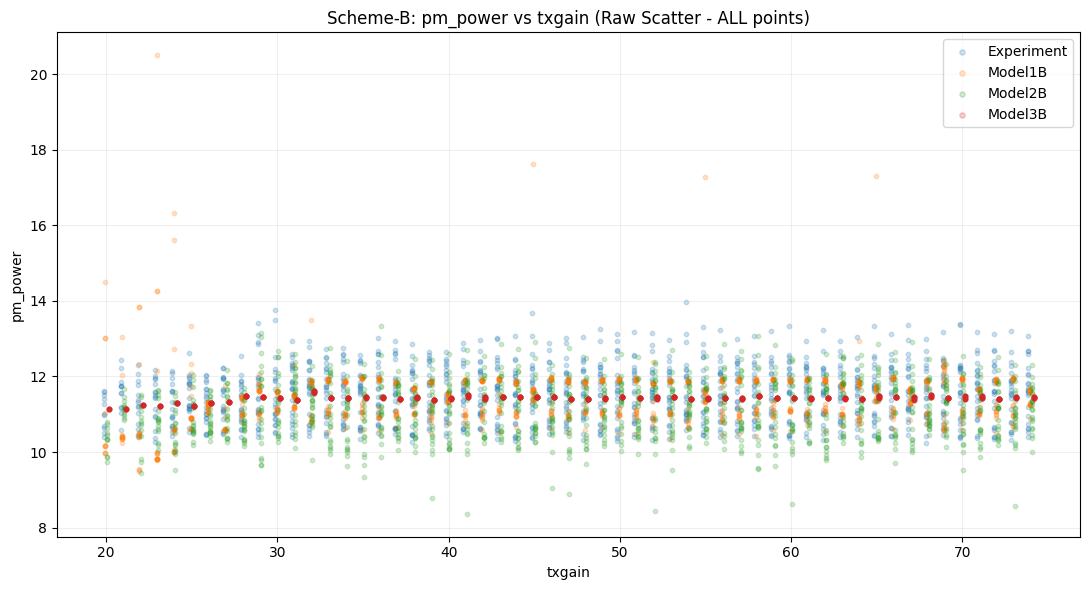

Scheme-B: pm_power vs txgain (Raw Scatter - ALL points)
Total points plotted (raw): 1158
[Model1B] MSE=0.6831 RMSE=0.8265 MAE=0.5125 MRE=4.42%
[Model2B] MSE=0.4018 RMSE=0.6339 MAE=0.5102 MRE=4.38%
[Model3B] MSE=0.5339 RMSE=0.7307 MAE=0.6075 MRE=5.21%


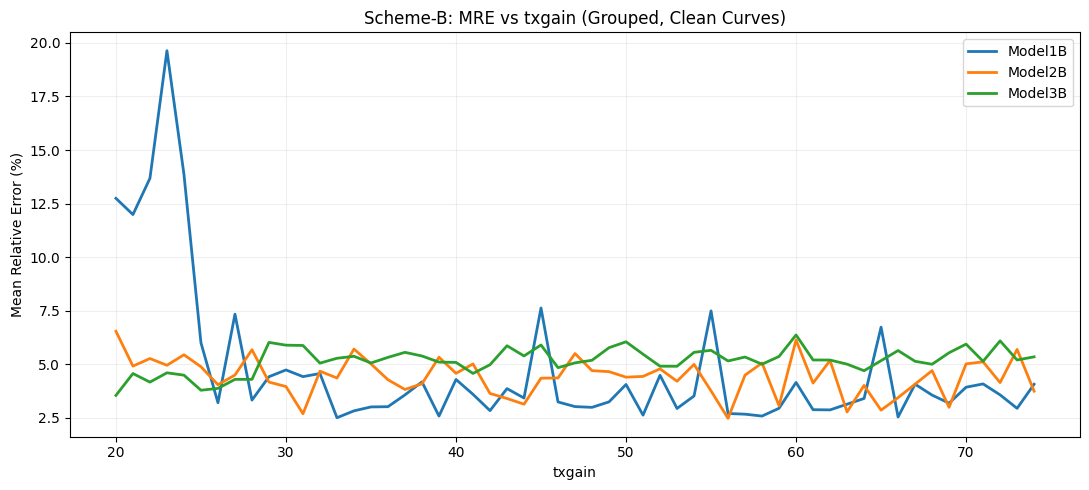

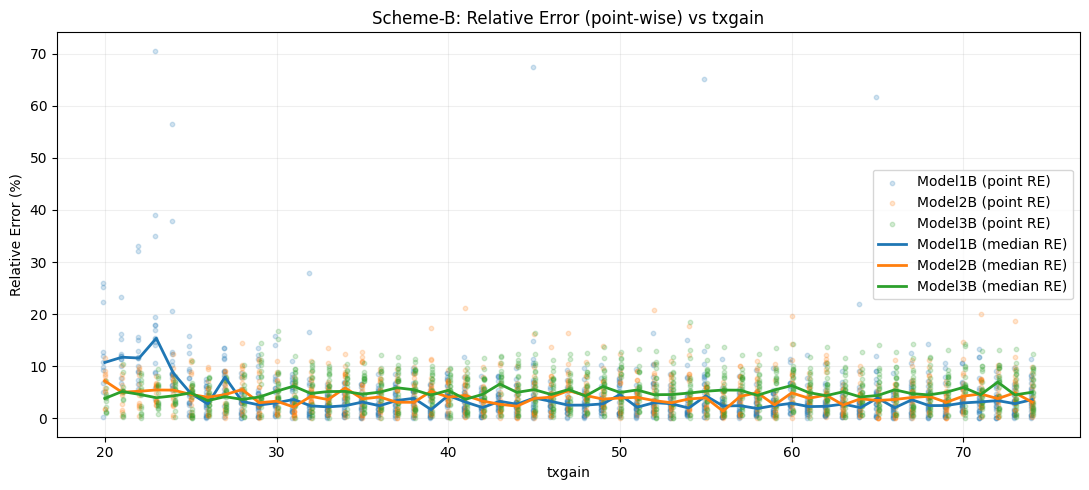

Scheme-B: Relative Error (point-wise) vs txgain
Total points: 1158
Point-RE mean:   M1=4.42% | M2=4.38% | M3=5.21%
Point-RE median: M1=3.05% | M2=3.88% | M3=4.97%


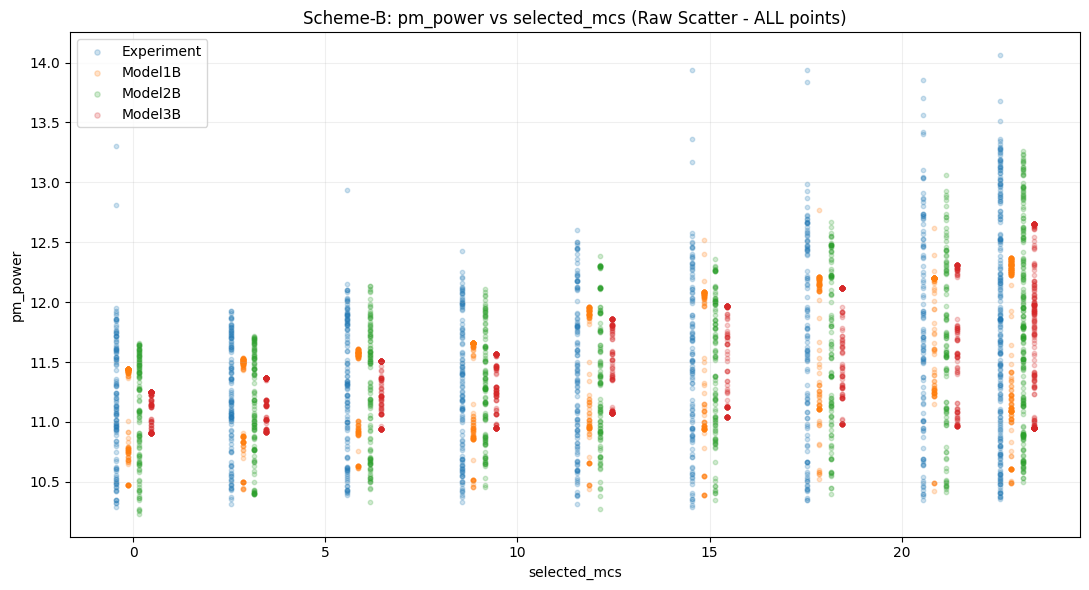

Scheme-B: pm_power vs selected_mcs (Raw Scatter - ALL points)
Total points plotted (raw): 1156
[Model1B] MSE=0.2243 RMSE=0.4736 MAE=0.3611 MRE=3.10%
[Model2B] MSE=0.1064 RMSE=0.3261 MAE=0.2334 MRE=2.01%
[Model3B] MSE=0.1686 RMSE=0.4106 MAE=0.3261 MRE=2.81%


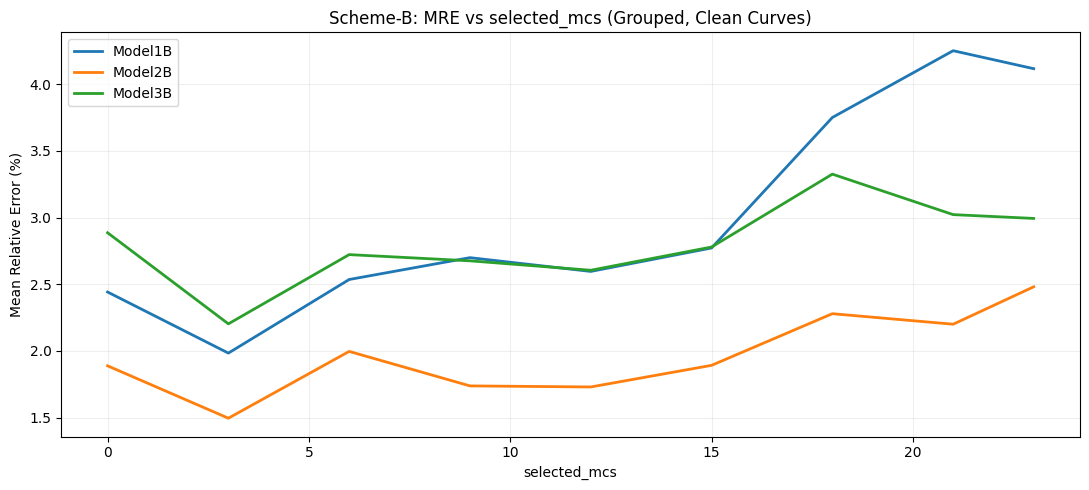

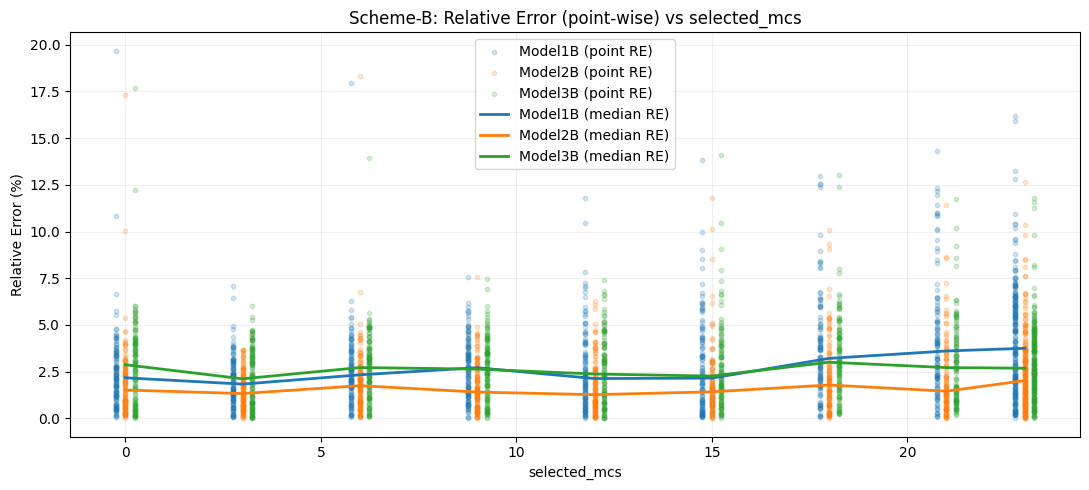

Scheme-B: Relative Error (point-wise) vs selected_mcs
Total points: 1156
Point-RE mean:   M1=3.10% | M2=2.01% | M3=2.81%
Point-RE median: M1=2.53% | M2=1.56% | M3=2.63%


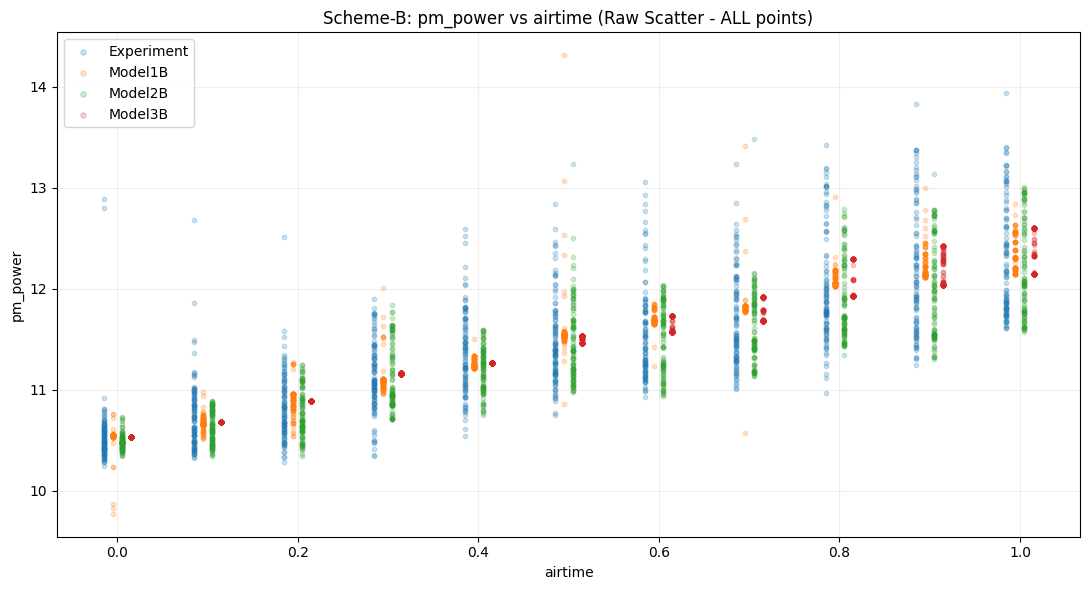

Scheme-B: pm_power vs airtime (Raw Scatter - ALL points)
Total points plotted (raw): 1159
[Model1B] MSE=0.2040 RMSE=0.4516 MAE=0.3429 MRE=2.95%
[Model2B] MSE=0.1248 RMSE=0.3533 MAE=0.2412 MRE=2.07%
[Model3B] MSE=0.1557 RMSE=0.3946 MAE=0.2988 MRE=2.57%


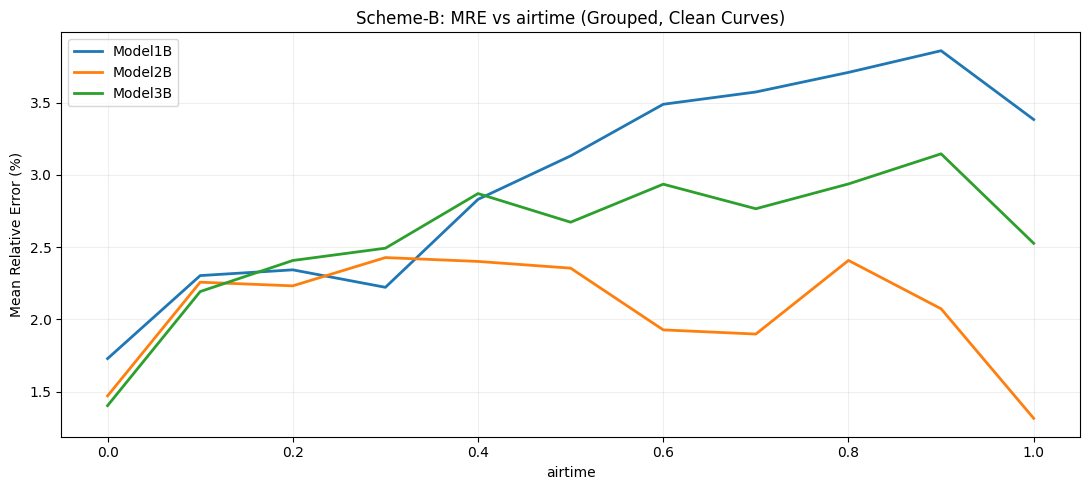

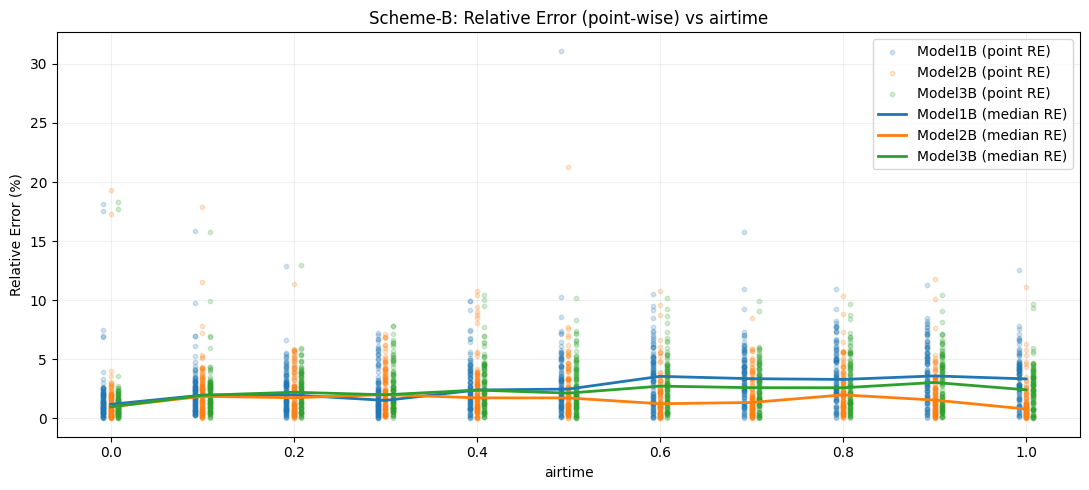

Scheme-B: Relative Error (point-wise) vs airtime
Total points: 1159
Point-RE mean:   M1=2.95% | M2=2.07% | M3=2.57%
Point-RE median: M1=2.45% | M2=1.45% | M3=2.11%


In [18]:
# ============================================================
# SCATTER (ALL POINTS) + CLEAN MRE CURVES — Scheme B
# Compare Model1B vs Model2B vs Model3B
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


# ------------------------------------------------------------
# 0) Metrics
# ------------------------------------------------------------
def relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return (np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100

def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100)

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    mre = mean_relative_error(y_true, y_pred)
    return mse, rmse, mae, mre


# ------------------------------------------------------------
# 1) Helper: robustly fetch prediction key 
# ------------------------------------------------------------
def _pick_pred_key(d, candidates):
    for k in candidates:
        if k in d:
            return k
    raise KeyError(f"Cannot find prediction key in dict. Tried: {candidates}. Keys={list(d.keys())}")

def _as_float(x):
    try:
        return float(x)
    except Exception:
        return float(np.asarray(x).item())


# ------------------------------------------------------------
# 2) Build unified raw DF for scheme B (concatenate all slices)
# ------------------------------------------------------------
def build_raw_test_dataframe_B(exp_name, xcol, test_outputs_m1B, test_outputs_m2B, test_outputs_m3B):
    """
    Scheme B: each slice_value has its own trained model + its own test set.
    We concatenate ALL slice test points into one big df_plot for scatter/MRE curves.
    """

    d_m1 = test_outputs_m1B[exp_name]
    d_m2 = test_outputs_m2B[exp_name]
    d_m3 = test_outputs_m3B[exp_name]

    def norm_map(d):
        mp = {}
        for k, v in d.items():
            mp[_as_float(k)] = v
        return mp

    m1 = norm_map(d_m1)
    m2 = norm_map(d_m2)
    m3 = norm_map(d_m3)

    common_keys = sorted(set(m1.keys()) & set(m2.keys()) & set(m3.keys()))
    if len(common_keys) == 0:
        raise ValueError(f"No common slice keys for exp={exp_name}. "
                         f"m1={len(m1)}, m2={len(m2)}, m3={len(m3)}")

    rows = []

    for s in common_keys:

        d1 = m1[s]
        d2 = m2[s]
        d3 = m3[s]

        
        k1 = _pick_pred_key(d1, ["y_pred_m1B", "y_pred_m1", "y_pred"])
        k2 = _pick_pred_key(d2, ["y_pred_m2B", "y_pred_m2", "y_pred"])
        k3 = _pick_pred_key(d3, ["y_pred_m3B", "y_pred_m3", "y_pred"])

        y_true = np.asarray(d1["y_true"]).reshape(-1)
        y_m1   = np.asarray(d1[k1]).reshape(-1)
        y_m2   = np.asarray(d2[k2]).reshape(-1)
        y_m3   = np.asarray(d3[k3]).reshape(-1)

        
        n = min(len(y_true), len(y_m1), len(y_m2), len(y_m3))
        if n == 0:
            continue
        
        y_true, y_m1, y_m2, y_m3 = y_true[:n], y_m1[:n], y_m2[:n], y_m3[:n]
        x = np.full(n, s, dtype=float)

        rows.append(pd.DataFrame({
            xcol: x,
            "y_true": y_true,
            "y_pred_m1": y_m1,
            "y_pred_m2": y_m2,
            "y_pred_m3": y_m3,
            "slice_value": s
        }))

    if len(rows) == 0:
        raise ValueError(f"Rows empty for exp={exp_name}. Possibly all slices had n==0 after alignment.")

    df_plot = pd.concat(rows, ignore_index=True)

    df_plot = df_plot.dropna(subset=[xcol, "y_true"]).copy()
    return df_plot


# ------------------------------------------------------------
# 3) Full raw scatter (ALL points) with horizontal offsets
# ------------------------------------------------------------
def plot_raw_scatter_with_offset_full(
    df_plot,
    xcol,
    title,
    offset_fraction=0.03,
    point_size=10,
    alpha=0.25,
    figsize=(11, 6)
):
    d = df_plot.dropna().copy()
    d = d.sort_values(xcol)

    x = d[xcol].to_numpy()
    x_unique = np.unique(x)
    unique_ratio = len(x_unique) / max(len(x), 1)

    # scheme B is usually discrete slices, but keep auto logic
    if len(x_unique) <= 60 or unique_ratio < 0.02:
        if len(x_unique) > 1:
            steps = np.diff(np.sort(x_unique))
            steps = steps[steps > 0]
            step = float(np.median(steps)) if len(steps) else 1.0
        else:
            step = 1.0
        dx = 0.1 * step
    else:
        x_min, x_max = float(np.min(x)), float(np.max(x))
        x_range = max(x_max - x_min, 1e-9)
        dx = offset_fraction * x_range

    offsets = {"exp": -1.5 * dx, "m1": -0.5 * dx, "m2": 0.5 * dx, "m3": 1.5 * dx}

    # metrics
    m1 = compute_metrics(d["y_true"], d["y_pred_m1"])
    m2 = compute_metrics(d["y_true"], d["y_pred_m2"])
    m3 = compute_metrics(d["y_true"], d["y_pred_m3"])

    plt.figure(figsize=figsize)
    plt.scatter(x + offsets["exp"], d["y_true"],    s=point_size, alpha=alpha, label="Experiment")
    plt.scatter(x + offsets["m1"],  d["y_pred_m1"], s=point_size, alpha=alpha, label="Model1B")
    plt.scatter(x + offsets["m2"],  d["y_pred_m2"], s=point_size, alpha=alpha, label="Model2B")
    plt.scatter(x + offsets["m3"],  d["y_pred_m3"], s=point_size, alpha=alpha, label="Model3B")

    plt.xlabel(xcol)
    plt.ylabel("pm_power")
    plt.title(title)
    plt.grid(True, alpha=0.2)
    plt.legend(markerscale=1.2, frameon=True)
    plt.tight_layout()
    plt.show()

    print("=" * 60)
    print(title)
    print(f"Total points plotted (raw): {len(d)}")
    print(f"[Model1B] MSE={m1[0]:.4f} RMSE={m1[1]:.4f} MAE={m1[2]:.4f} MRE={m1[3]:.2f}%")
    print(f"[Model2B] MSE={m2[0]:.4f} RMSE={m2[1]:.4f} MAE={m2[2]:.4f} MRE={m2[3]:.2f}%")
    print(f"[Model3B] MSE={m3[0]:.4f} RMSE={m3[1]:.4f} MAE={m3[2]:.4f} MRE={m3[3]:.2f}%")
    print("=" * 60)


# ------------------------------------------------------------
# 4) Clean MRE curves (grouped by x)
# ------------------------------------------------------------



def group_mean_mre_curve(df_plot, xcol, pred_col, eps=1e-9, min_count=1):
    d = df_plot[[xcol, "y_true", pred_col]].dropna().copy()
    d["rel_err"] = (np.abs(d["y_true"] - d[pred_col]) / (np.abs(d["y_true"]) + eps)) * 100

    g = d.groupby(xcol).agg(
        mre=("rel_err", "mean"),
        n=("rel_err", "size")
    ).reset_index()

    g = g[g["n"] >= min_count].copy()
    g = g.sort_values(xcol)
    return g


def plot_pointwise_re_scatter(
    df_plot,
    xcol,
    title,
    eps=1e-9,
    point_size=10,
    alpha=0.20,
    figsize=(11, 5),
    show_group_curve=True,
    how="median",     # "mean" or "median"
    min_count=1
):
    """
    Point-wise Relative Error scatter:
      RE_i = |y_true_i - y_pred_i| / (|y_true_i| + eps) * 100

    show_group_curve=True will overlay grouped mean/median RE vs xcol.
    """

    d = df_plot[[xcol, "y_true", "y_pred_m1", "y_pred_m2", "y_pred_m3"]].dropna().copy()
    d = d.sort_values(xcol)

    # point-wise RE for each model
    d["re_m1"] = (np.abs(d["y_true"] - d["y_pred_m1"]) / (np.abs(d["y_true"]) + eps)) * 100
    d["re_m2"] = (np.abs(d["y_true"] - d["y_pred_m2"]) / (np.abs(d["y_true"]) + eps)) * 100
    d["re_m3"] = (np.abs(d["y_true"] - d["y_pred_m3"]) / (np.abs(d["y_true"]) + eps)) * 100

    # horizontal offsets (avoid overlap when x is discrete slices)
    x = d[xcol].to_numpy()
    x_unique = np.unique(x)
    if len(x_unique) > 1:
        steps = np.diff(np.sort(x_unique))
        steps = steps[steps > 0]
        step = float(np.median(steps)) if len(steps) else 1.0
    else:
        step = 1.0
    dx = 0.08 * step
    offsets = {"m1": -dx, "m2": 0.0, "m3": dx}

    plt.figure(figsize=figsize)
    plt.scatter(x + offsets["m1"], d["re_m1"], s=point_size, alpha=alpha, label="Model1B (point RE)")
    plt.scatter(x + offsets["m2"], d["re_m2"], s=point_size, alpha=alpha, label="Model2B (point RE)")
    plt.scatter(x + offsets["m3"], d["re_m3"], s=point_size, alpha=alpha, label="Model3B (point RE)")

    # optional grouped curve overlay
    if show_group_curve:
        if how not in ["mean", "median"]:
            raise ValueError("how must be 'mean' or 'median'")

        def _group_curve(re_col):
            g = d.groupby(xcol).agg(
                re=(re_col, how),
                n=(re_col, "size")
            ).reset_index()
            g = g[g["n"] >= min_count].sort_values(xcol)
            return g

        g1 = _group_curve("re_m1")
        g2 = _group_curve("re_m2")
        g3 = _group_curve("re_m3")

        plt.plot(g1[xcol], g1["re"], linewidth=2, label=f"Model1B ({how} RE)")
        plt.plot(g2[xcol], g2["re"], linewidth=2, label=f"Model2B ({how} RE)")
        plt.plot(g3[xcol], g3["re"], linewidth=2, label=f"Model3B ({how} RE)")

    plt.xlabel(xcol)
    plt.ylabel("Relative Error (%)")
    plt.title(title)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # quick stats
    print("=" * 60)
    print(title)
    print(f"Total points: {len(d)}")
    print(f"Point-RE mean:   M1={d['re_m1'].mean():.2f}% | M2={d['re_m2'].mean():.2f}% | M3={d['re_m3'].mean():.2f}%")
    print(f"Point-RE median: M1={d['re_m1'].median():.2f}% | M2={d['re_m2'].median():.2f}% | M3={d['re_m3'].median():.2f}%")
    print("=" * 60)



def plot_mre_curves_clean(df_plot, xcol, title, min_count=1, figsize=(11, 5)):
    g1 = group_mean_mre_curve(df_plot, xcol, "y_pred_m1", min_count=min_count)
    g2 = group_mean_mre_curve(df_plot, xcol, "y_pred_m2", min_count=min_count)
    g3 = group_mean_mre_curve(df_plot, xcol, "y_pred_m3", min_count=min_count)

    plt.figure(figsize=figsize)
    plt.plot(g1[xcol], g1["mre"], label="Model1B", linewidth=2)
    plt.plot(g2[xcol], g2["mre"], label="Model2B", linewidth=2)
    plt.plot(g3[xcol], g3["mre"], label="Model3B", linewidth=2)

    plt.xlabel(xcol)
    plt.ylabel("Mean Relative Error (%)")
    plt.title(title)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# 5) Run plots for gain / mcs / airtime (scheme B)
# ------------------------------------------------------------
# You MUST already have:
#   test_outputs_m1B, test_outputs_m2B, test_outputs_m3B
# in memory.

PLOT_CONFIG = {
    "gain":    ("txgain",        "Scheme-B: pm_power vs txgain (Raw Scatter - ALL points)"),
    "mcs":     ("selected_mcs",  "Scheme-B: pm_power vs selected_mcs (Raw Scatter - ALL points)"),
    "airtime": ("airtime",       "Scheme-B: pm_power vs airtime (Raw Scatter - ALL points)"),
}

import inspect
print(inspect.signature(build_raw_test_dataframe_B))


for exp_name, (xcol, title) in PLOT_CONFIG.items():
    df_plot = build_raw_test_dataframe_B(
        exp_name=exp_name,
        xcol=xcol,
        test_outputs_m1B=test_outputs_m1_slices,
        test_outputs_m2B=test_outputs_m2_slices,
        test_outputs_m3B=test_outputs_m3B
    )

    plot_raw_scatter_with_offset_full(
        df_plot=df_plot,
        xcol=xcol,
        title=title,
        offset_fraction=0.02,
        point_size=10,
        alpha=0.22,
        figsize=(11, 6)
    )

    plot_mre_curves_clean(
        df_plot=df_plot,
        xcol=xcol,
        title=f"Scheme-B: MRE vs {xcol} (Grouped, Clean Curves)",
        min_count=1
    )

    plot_pointwise_re_scatter(
        df_plot=df_plot,
        xcol=xcol,
        title=f"Scheme-B: Relative Error (point-wise) vs {xcol}",
        point_size=10,
        alpha=0.20,
        figsize=(11, 5),
        show_group_curve=True,  
        how="median",           
        min_count=1
    )

    
